<a href="https://colab.research.google.com/github/Susancoder/MyProject/blob/main/Prematchprediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
import pandas as pd

# Load matches dataset
matches = pd.read_csv("/content/drive/MyDrive/Dataset/matches.csv")

# Load deliveries dataset
deliveries = pd.read_csv("/content/drive/MyDrive/Dataset/deliveries.csv")

# Preview first few rows
print("Matches Dataset:")
print(matches.head(), "\n")

print("Deliveries Dataset:")
print(deliveries.head())


Matches Dataset:
       id   season        city        date match_type player_of_match  \
0  335982  2007/08   Bangalore  2008-04-18     League     BB McCullum   
1  335983  2007/08  Chandigarh  2008-04-19     League      MEK Hussey   
2  335984  2007/08       Delhi  2008-04-19     League     MF Maharoof   
3  335985  2007/08      Mumbai  2008-04-20     League      MV Boucher   
4  335986  2007/08     Kolkata  2008-04-20     League       DJ Hussey   

                                        venue                        team1  \
0                       M Chinnaswamy Stadium  Royal Challengers Bangalore   
1  Punjab Cricket Association Stadium, Mohali              Kings XI Punjab   
2                            Feroz Shah Kotla             Delhi Daredevils   
3                            Wankhede Stadium               Mumbai Indians   
4                                Eden Gardens        Kolkata Knight Riders   

                         team2                  toss_winner toss_decision  

In [2]:
# 1. Drop matches with no result
matches_cleaned = matches[matches['result'].str.lower() != 'no result']

# 2. Drop matches with missing winner (unresolved or ties with no winner)
matches_cleaned = matches_cleaned[~matches_cleaned['winner'].isnull()]

# 3. Drop matches where result is 'tie' and no clear method (e.g., no Super Over)
matches_cleaned = matches_cleaned[~((matches_cleaned['result'].str.lower() == 'tie') & (matches_cleaned['method'].isnull()))]

# 4. Keep D/L matches (if method is not null) only if there is a winner (already filtered above)

# Reset index
matches_cleaned = matches_cleaned.reset_index(drop=True)

print(f"✅ Cleaned matches shape: {matches_cleaned.shape}")
print(matches_cleaned[['id', 'team1', 'team2', 'winner', 'result', 'method']].head())


✅ Cleaned matches shape: (1076, 20)
       id                        team1                        team2  \
0  335982  Royal Challengers Bangalore        Kolkata Knight Riders   
1  335983              Kings XI Punjab          Chennai Super Kings   
2  335984             Delhi Daredevils             Rajasthan Royals   
3  335985               Mumbai Indians  Royal Challengers Bangalore   
4  335986        Kolkata Knight Riders              Deccan Chargers   

                        winner   result method  
0        Kolkata Knight Riders     runs    NaN  
1          Chennai Super Kings     runs    NaN  
2             Delhi Daredevils  wickets    NaN  
3  Royal Challengers Bangalore  wickets    NaN  
4        Kolkata Knight Riders  wickets    NaN  


In [3]:
# Step 1: Combine all team name columns from both datasets
team_cols_matches = ['team1', 'team2', 'toss_winner', 'winner']
team_cols_deliveries = ['batting_team', 'bowling_team']

# Step 2: Extract all unique team names
unique_teams = set()
for col in team_cols_matches:
    unique_teams.update(matches_cleaned[col].dropna().unique())

for col in team_cols_deliveries:
    unique_teams.update(deliveries[col].dropna().unique())

print("📋 Unique Team Names Found:")
print(sorted(unique_teams))


📋 Unique Team Names Found:
['Chennai Super Kings', 'Deccan Chargers', 'Delhi Capitals', 'Delhi Daredevils', 'Gujarat Lions', 'Gujarat Titans', 'Kings XI Punjab', 'Kochi Tuskers Kerala', 'Kolkata Knight Riders', 'Lucknow Super Giants', 'Mumbai Indians', 'Pune Warriors', 'Punjab Kings', 'Rajasthan Royals', 'Rising Pune Supergiant', 'Rising Pune Supergiants', 'Royal Challengers Bangalore', 'Royal Challengers Bengaluru', 'Sunrisers Hyderabad']


In [5]:
team_name_map = {
    'Delhi Daredevils': 'Delhi Capitals',
    'Kings XI Punjab': 'Punjab Kings',
    'Royal Challengers Bangalore' : 'Royal Challengers Bengaluru',
    'Rising Pune Supergiants': 'Rising Pune Supergiant'
}


In [6]:
# Apply mapping to matches_cleaned
for col in ['team1', 'team2', 'toss_winner', 'winner']:
    matches_cleaned[col] = matches_cleaned[col].replace(team_name_map)

# Apply mapping to deliveries
for col in ['batting_team', 'bowling_team']:
    deliveries[col] = deliveries[col].replace(team_name_map)


In [8]:
import numpy as np

# Step 1: Filter to innings 1 and 2 only
valid_innings = deliveries[deliveries['inning'].isin([1, 2])]

# Step 2: Aggregate total runs per match per inning
inning_totals = valid_innings.groupby(['match_id', 'inning'])['total_runs'].sum().reset_index()

# Step 3: Pivot into wide format
innings_pivot = inning_totals.pivot(index='match_id', columns='inning', values='total_runs')
innings_pivot.columns = ['first_innings_runs', 'second_innings_runs']
innings_pivot = innings_pivot.reset_index()

# Step 4: Detect and treat outliers using IQR method
def treat_outliers_iqr(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return series.where((series >= lower) & (series <= upper), np.nan)

innings_pivot['first_innings_runs'] = treat_outliers_iqr(innings_pivot['first_innings_runs'])
innings_pivot['second_innings_runs'] = treat_outliers_iqr(innings_pivot['second_innings_runs'])

# Optional: Print summary
print("✅ Outlier treatment complete.")
print(innings_pivot.describe())
print(innings_pivot.isna().sum())



✅ Outlier treatment complete.
           match_id  first_innings_runs  second_innings_runs
count  1.095000e+03         1075.000000          1069.000000
mean   9.048283e+05          165.683721           153.496726
std    3.677402e+05           29.489361            28.679901
min    3.359820e+05           84.000000            76.000000
25%    5.483315e+05          146.000000           135.000000
50%    9.809610e+05          165.000000           154.000000
75%    1.254062e+06          186.000000           173.000000
max    1.426312e+06          246.000000           226.000000
match_id                0
first_innings_runs     20
second_innings_runs    26
dtype: int64


In [9]:
from sklearn.impute import KNNImputer

# Step 1: Rename 'id' to 'match_id' to merge
matches_cleaned_merged = matches_cleaned.rename(columns={'id': 'match_id'})

# Step 2: Merge innings totals to matches
matches_combined = pd.merge(matches_cleaned_merged, innings_pivot, on='match_id', how='left')

# Step 3: Select numerical features for KNN Imputation
features_to_impute = ['first_innings_runs', 'second_innings_runs']

# Create imputer
imputer = KNNImputer(n_neighbors=3)

# Apply imputation
matches_combined[features_to_impute] = imputer.fit_transform(matches_combined[features_to_impute])

# ✅ Done
print("✅ KNN interpolation complete. Missing values filled:")
print(matches_combined[features_to_impute].isnull().sum())


✅ KNN interpolation complete. Missing values filled:
first_innings_runs     0
second_innings_runs    0
dtype: int64


In [10]:
# 1. Toss winner flag: 1 if toss winner == team1, else 0
matches_combined['toss_winner_flag'] = (matches_combined['toss_winner'] == matches_combined['team1']).astype(int)

# 2. Toss decision encoding: 1 = field, 0 = bat
matches_combined['toss_decision_encoded'] = matches_combined['toss_decision'].map({'field': 1, 'bat': 0})


In [11]:
print(matches_combined[['toss_winner', 'team1', 'toss_winner_flag', 'toss_decision', 'toss_decision_encoded']].head())


                   toss_winner                        team1  toss_winner_flag  \
0  Royal Challengers Bengaluru  Royal Challengers Bengaluru                 1   
1          Chennai Super Kings                 Punjab Kings                 0   
2             Rajasthan Royals               Delhi Capitals                 0   
3               Mumbai Indians               Mumbai Indians                 1   
4              Deccan Chargers        Kolkata Knight Riders                 0   

  toss_decision  toss_decision_encoded  
0         field                      1  
1           bat                      0  
2           bat                      0  
3           bat                      0  
4           bat                      0  


In [19]:
unique_venues = matches_combined["venue"].dropna().unique()
print("Unique Venues in Dataset:")
print(sorted(unique_venues))


Unique Venues in Dataset:
['Arun Jaitley Stadium', 'Arun Jaitley Stadium, Delhi', 'Barabati Stadium', 'Barsapara Cricket Stadium, Guwahati', 'Bharat Ratna Shri Atal Bihari Vajpayee Ekana Cricket Stadium, Lucknow', 'Brabourne Stadium', 'Brabourne Stadium, Mumbai', 'Buffalo Park', 'De Beers Diamond Oval', 'Dr DY Patil Sports Academy', 'Dr DY Patil Sports Academy, Mumbai', 'Dr. Y.S. Rajasekhara Reddy ACA-VDCA Cricket Stadium', 'Dr. Y.S. Rajasekhara Reddy ACA-VDCA Cricket Stadium, Visakhapatnam', 'Dubai International Cricket Stadium', 'Eden Gardens', 'Eden Gardens, Kolkata', 'Feroz Shah Kotla', 'Green Park', 'Himachal Pradesh Cricket Association Stadium', 'Himachal Pradesh Cricket Association Stadium, Dharamsala', 'Holkar Cricket Stadium', 'JSCA International Stadium Complex', 'Kingsmead', 'M Chinnaswamy Stadium', 'M Chinnaswamy Stadium, Bengaluru', 'M.Chinnaswamy Stadium', 'MA Chidambaram Stadium', 'MA Chidambaram Stadium, Chepauk', 'MA Chidambaram Stadium, Chepauk, Chennai', 'Maharaja Ya

In [20]:
VENUE_CANONICAL_MAP = {
    # Delhi
    "Feroz Shah Kotla": "Arun Jaitley Stadium, Delhi",
    "Arun Jaitley Stadium": "Arun Jaitley Stadium, Delhi",
    "Arun Jaitley Stadium, Delhi": "Arun Jaitley Stadium, Delhi",

    # Bengaluru
    "M Chinnaswamy Stadium": "M Chinnaswamy Stadium, Bengaluru",
    "M.Chinnaswamy Stadium": "M Chinnaswamy Stadium, Bengaluru",
    "M Chinnaswamy Stadium, Bengaluru": "M Chinnaswamy Stadium, Bengaluru",

    # Chennai
    "MA Chidambaram Stadium": "MA Chidambaram Stadium, Chennai",
    "MA Chidambaram Stadium, Chepauk": "MA Chidambaram Stadium, Chennai",
    "MA Chidambaram Stadium, Chepauk, Chennai": "MA Chidambaram Stadium, Chennai",

    # Hyderabad
    "Rajiv Gandhi International Stadium": "Rajiv Gandhi International Stadium, Hyderabad",
    "Rajiv Gandhi International Stadium, Uppal": "Rajiv Gandhi International Stadium, Hyderabad",
    "Rajiv Gandhi International Stadium, Uppal, Hyderabad": "Rajiv Gandhi International Stadium, Hyderabad",

    # Mohali (Punjab Kings)
    "Punjab Cricket Association Stadium, Mohali": "PCA Stadium, Mohali",
    "Punjab Cricket Association IS Bindra Stadium": "PCA Stadium, Mohali",
    "Punjab Cricket Association IS Bindra Stadium, Mohali": "PCA Stadium, Mohali",
    "Punjab Cricket Association IS Bindra Stadium, Mohali, Chandigarh": "PCA Stadium, Mohali",

    # Mumbai
    "Wankhede Stadium": "Wankhede Stadium, Mumbai",
    "Wankhede Stadium, Mumbai": "Wankhede Stadium, Mumbai",
    "Dr DY Patil Sports Academy": "Dr DY Patil Sports Academy, Mumbai",
    "Dr DY Patil Sports Academy, Mumbai": "Dr DY Patil Sports Academy, Mumbai",
    "Brabourne Stadium": "Brabourne Stadium, Mumbai",
    "Brabourne Stadium, Mumbai": "Brabourne Stadium, Mumbai",

    # Jaipur
    "Sawai Mansingh Stadium": "Sawai Mansingh Stadium, Jaipur",
    "Sawai Mansingh Stadium, Jaipur": "Sawai Mansingh Stadium, Jaipur",

    # Pune
    "Maharashtra Cricket Association Stadium": "MCA Stadium, Pune",
    "Maharashtra Cricket Association Stadium, Pune": "MCA Stadium, Pune",
    "Subrata Roy Sahara Stadium": "MCA Stadium, Pune",

    # Rajkot
    "Saurashtra Cricket Association Stadium": "Saurashtra Stadium, Rajkot",

    # Kochi
    "Nehru Stadium": "Nehru Stadium, Kochi"
}


In [21]:
matches_combined["venue_clean"] = matches_combined["venue"].replace(VENUE_CANONICAL_MAP)


In [22]:
TEAM_HOME_VENUES = {
    "Chennai Super Kings": {"MA Chidambaram Stadium, Chennai"},
    "Mumbai Indians": {"Wankhede Stadium, Mumbai", "Dr DY Patil Sports Academy, Mumbai", "Brabourne Stadium, Mumbai"},
    "Royal Challengers Bengaluru": {"M Chinnaswamy Stadium, Bengaluru"},
    "Kolkata Knight Riders": {"Eden Gardens, Kolkata"},
    "Sunrisers Hyderabad": {"Rajiv Gandhi International Stadium, Hyderabad"},
    "Delhi Capitals": {"Arun Jaitley Stadium, Delhi"},
    "Punjab Kings": {"PCA Stadium, Mohali", "Himachal Pradesh Cricket Association Stadium, Dharamsala"},
    "Rajasthan Royals": {"Sawai Mansingh Stadium, Jaipur"},
    "Gujarat Titans": {"Narendra Modi Stadium, Ahmedabad"},
    "Lucknow Super Giants": {"Bharat Ratna Shri Atal Bihari Vajpayee Ekana Cricket Stadium, Lucknow"},
    # Old
    "Deccan Chargers": {"Rajiv Gandhi International Stadium, Hyderabad"},
    "Rising Pune Supergiant": {"MCA Stadium, Pune"},
    "Pune Warriors": {"MCA Stadium, Pune"},
    "Gujarat Lions": {"Saurashtra Stadium, Rajkot"},
    "Kochi Tuskers Kerala": {"Nehru Stadium, Kochi"}
}


In [23]:
def is_home_by_venue(team, venue):
    if pd.isna(team) or pd.isna(venue):
        return 0
    homes = TEAM_HOME_VENUES.get(team, set())
    return int(venue in homes)

matches_combined["home_advantage_flag"] = [
    is_home_by_venue(team, venue) for team, venue in zip(matches_combined["team1"], matches_combined["venue_clean"])
]

print(matches_combined[["team1", "venue", "venue_clean", "home_advantage_flag"]].head(20))


                          team1                                       venue  \
0   Royal Challengers Bengaluru                       M Chinnaswamy Stadium   
1                  Punjab Kings  Punjab Cricket Association Stadium, Mohali   
2                Delhi Capitals                            Feroz Shah Kotla   
3                Mumbai Indians                            Wankhede Stadium   
4         Kolkata Knight Riders                                Eden Gardens   
5              Rajasthan Royals                      Sawai Mansingh Stadium   
6               Deccan Chargers   Rajiv Gandhi International Stadium, Uppal   
7           Chennai Super Kings             MA Chidambaram Stadium, Chepauk   
8               Deccan Chargers   Rajiv Gandhi International Stadium, Uppal   
9                  Punjab Kings  Punjab Cricket Association Stadium, Mohali   
10  Royal Challengers Bengaluru                       M Chinnaswamy Stadium   
11          Chennai Super Kings             MA Chida

In [24]:
# Filter only powerplay overs (1–6)
powerplay = deliveries[deliveries["over"].between(1, 6)]


In [25]:
# Calculate runs and wickets per match, per inning, per team
pp_stats = powerplay.groupby(["match_id", "inning", "batting_team"]).agg(
    powerplay_runs = ("total_runs", "sum"),
    powerplay_wickets = ("player_dismissed", lambda x: x.notna().sum())
).reset_index()

print(pp_stats.head())


   match_id  inning                 batting_team  powerplay_runs  \
0    335982       1        Kolkata Knight Riders              65   
1    335982       2  Royal Challengers Bengaluru              29   
2    335983       1          Chennai Super Kings              57   
3    335983       2                 Punjab Kings              60   
4    335984       1             Rajasthan Royals              37   

   powerplay_wickets  
0                  1  
1                  4  
2                  2  
3                  1  
4                  3  


In [26]:
# Pivot to get first and second innings separately
pp_pivot = pp_stats.pivot(index="match_id", columns="inning", values=["powerplay_runs", "powerplay_wickets"])
pp_pivot.columns = ["pp_runs_innings1", "pp_runs_innings2", "pp_wkts_innings1", "pp_wkts_innings2"]
pp_pivot = pp_pivot.reset_index()

print(pp_pivot.head())


   match_id  pp_runs_innings1  pp_runs_innings2  pp_wkts_innings1  \
0    335982              65.0              29.0               1.0   
1    335983              57.0              60.0               2.0   
2    335984              37.0              51.0               3.0   
3    335985              46.0              36.0               3.0   
4    335986              36.0              27.0               2.0   

   pp_wkts_innings2  
0               4.0  
1               1.0  
2               1.0  
3               1.0  
4               3.0  


In [27]:
# Merge with matches dataset
matches_combined = matches_combined.merge(pp_pivot, on="match_id", how="left")

print(matches_combined[["match_id", "team1", "team2",
                        "pp_runs_innings1", "pp_wkts_innings1",
                        "pp_runs_innings2", "pp_wkts_innings2"]].head(10))


   match_id                        team1                        team2  \
0    335982  Royal Challengers Bengaluru        Kolkata Knight Riders   
1    335983                 Punjab Kings          Chennai Super Kings   
2    335984               Delhi Capitals             Rajasthan Royals   
3    335985               Mumbai Indians  Royal Challengers Bengaluru   
4    335986        Kolkata Knight Riders              Deccan Chargers   
5    335987             Rajasthan Royals                 Punjab Kings   
6    335988              Deccan Chargers               Delhi Capitals   
7    335989          Chennai Super Kings               Mumbai Indians   
8    335990              Deccan Chargers             Rajasthan Royals   
9    335991                 Punjab Kings               Mumbai Indians   

   pp_runs_innings1  pp_wkts_innings1  pp_runs_innings2  pp_wkts_innings2  
0              65.0               1.0              29.0               4.0  
1              57.0               2.0       

In [30]:
# Make sure 'date' is datetime
matches_combined["date"] = pd.to_datetime(matches_combined["date"])

# ----------------------------
# 1. Build per-team match perspective
# ----------------------------
team_rows = []
for _, row in matches_combined.iterrows():
    if pd.isna(row["team1"]) or pd.isna(row["team2"]):
        continue

    # Team1 perspective
    team_rows.append({
        "match_id": row["match_id"],
        "date": row["date"],
        "team": row["team1"],
        "opponent": row["team2"],
        "won": int(row["winner"] == row["team1"])
    })

    # Team2 perspective
    team_rows.append({
        "match_id": row["match_id"],
        "date": row["date"],
        "team": row["team2"],
        "opponent": row["team1"],
        "won": int(row["winner"] == row["team2"])
    })

team_matches = pd.DataFrame(team_rows)

# ----------------------------
# 2. Sort + compute rolling win ratio
# ----------------------------
K = 5  # window size (last 5 matches)
team_matches = team_matches.sort_values(["team", "date", "match_id"]).reset_index(drop=True)

# Use transform to avoid index mismatch
team_matches["recent_win_ratio"] = (
    team_matches.groupby("team")["won"]
    .transform(lambda s: s.shift(1).rolling(K, min_periods=1).mean())
)

print("✅ Team-level recent win ratio computed")
print(team_matches.head(10))

# ----------------------------
# 3. Merge back into matches_combined
# ----------------------------
# Team1 side
t1 = team_matches.rename(
    columns={"team":"team1", "recent_win_ratio":"team1_recent_win_ratio"}
)[["match_id","team1","team1_recent_win_ratio"]]

# Team2 side
t2 = team_matches.rename(
    columns={"team":"team2", "recent_win_ratio":"team2_recent_win_ratio"}
)[["match_id","team2","team2_recent_win_ratio"]]

# Merge into main match dataset
matches_with_recent = (
    matches_combined
    .merge(t1, on=["match_id","team1"], how="left")
    .merge(t2, on=["match_id","team2"], how="left")
)

# ----------------------------
# 4. Create difference feature
# ----------------------------
matches_with_recent["recent_win_ratio_diff"] = (
    matches_with_recent["team1_recent_win_ratio"] -
    matches_with_recent["team2_recent_win_ratio"]
)

print("✅ recent_win_ratio_diff added")
print(matches_with_recent[[
    "match_id","team1","team2",
    "team1_recent_win_ratio","team2_recent_win_ratio",
    "recent_win_ratio_diff"
]].head(15))

✅ Team-level recent win ratio computed
   match_id       date                 team                     opponent  won  \
0    335983 2008-04-19  Chennai Super Kings                 Punjab Kings    1   
1    335989 2008-04-23  Chennai Super Kings               Mumbai Indians    1   
2    335993 2008-04-26  Chennai Super Kings        Kolkata Knight Riders    1   
3    335996 2008-04-28  Chennai Super Kings  Royal Challengers Bengaluru    1   
4    336001 2008-05-02  Chennai Super Kings               Delhi Capitals    0   
5    336005 2008-05-04  Chennai Super Kings             Rajasthan Royals    0   
6    336007 2008-05-06  Chennai Super Kings              Deccan Chargers    0   
7    336009 2008-05-08  Chennai Super Kings               Delhi Capitals    1   
8    336013 2008-05-10  Chennai Super Kings                 Punjab Kings    1   
9    336018 2008-05-14  Chennai Super Kings               Mumbai Indians    0   

   recent_win_ratio  
0               NaN  
1               1.0  
2  

In [32]:
# ----------------------------
# Net Run Rate Differential (NRR diff)
# ----------------------------

# Step 1: Calculate innings totals (runs + balls)
innings_summary = (
    deliveries.groupby(["match_id", "inning", "batting_team"])
    .agg(runs=("total_runs", "sum"), balls=("ball", "count"))
    .reset_index()
)

# Convert balls to overs
innings_summary["overs"] = innings_summary["balls"] / 6.0
innings_summary["run_rate"] = np.where(
    innings_summary["overs"] > 0,
    innings_summary["runs"] / innings_summary["overs"],
    0.0
)

# Step 2: Pair up innings to get team vs opponent run rate in same match
# Keep only first 2 innings (ignore Super Overs)
innings_summary = innings_summary[innings_summary["inning"].isin([1, 2])]

# Self-join to get opponent run rate
opp_summary = innings_summary.copy()
opp_summary["inning"] = opp_summary["inning"].map({1:2, 2:1})  # swap innings

nrr_pairs = pd.merge(
    innings_summary,
    opp_summary[["match_id", "inning", "batting_team", "run_rate"]],
    on=["match_id", "inning"],
    suffixes=("", "_opp")
)

# Filter so team != opponent
nrr_pairs = nrr_pairs[nrr_pairs["batting_team"] != nrr_pairs["batting_team_opp"]].copy()
nrr_pairs["match_nrr"] = nrr_pairs["run_rate"] - nrr_pairs["run_rate_opp"]

# Step 3: Merge with match dates for chronological ordering
nrr_pairs = nrr_pairs.merge(
    matches_with_recent[["match_id", "date"]],
    on="match_id",
    how="left"
).sort_values(["batting_team", "date"])

# Step 4: Compute rolling average NRR for each team (last K matches)
K = 5
nrr_pairs["recent_nrr"] = (
    nrr_pairs.groupby("batting_team")["match_nrr"]
    .transform(lambda s: s.shift(1).rolling(K, min_periods=1).mean())
)

# Step 5: Pivot to team1 / team2 perspective
t1_nrr = nrr_pairs.rename(columns={"batting_team": "team1", "recent_nrr": "team1_nrr"})[
    ["match_id", "team1", "team1_nrr"]
]
t2_nrr = nrr_pairs.rename(columns={"batting_team": "team2", "recent_nrr": "team2_nrr"})[
    ["match_id", "team2", "team2_nrr"]
]

# Merge into main dataset
matches_with_recent = (
    matches_with_recent
    .merge(t1_nrr, on=["match_id", "team1"], how="left")
    .merge(t2_nrr, on=["match_id", "team2"], how="left")
)

# Step 6: Final NRR differential
matches_with_recent["nrr_diff"] = (
    matches_with_recent["team1_nrr"] - matches_with_recent["team2_nrr"]
)

print("✅ NRR differential added")
print(matches_with_recent[[
    "match_id","team1","team2","team1_nrr","team2_nrr","nrr_diff"
]].head(15))


✅ NRR differential added
    match_id                        team1                        team2  \
0     335982  Royal Challengers Bengaluru        Kolkata Knight Riders   
1     335983                 Punjab Kings          Chennai Super Kings   
2     335984               Delhi Capitals             Rajasthan Royals   
3     335985               Mumbai Indians  Royal Challengers Bengaluru   
4     335986        Kolkata Knight Riders              Deccan Chargers   
5     335987             Rajasthan Royals                 Punjab Kings   
6     335988              Deccan Chargers               Delhi Capitals   
7     335989          Chennai Super Kings               Mumbai Indians   
8     335990              Deccan Chargers             Rajasthan Royals   
9     335991                 Punjab Kings               Mumbai Indians   
10    335992  Royal Challengers Bengaluru             Rajasthan Royals   
11    335993          Chennai Super Kings        Kolkata Knight Riders   
12    335994 

In [33]:
# ----------------------------
# Head-to-Head Win Ratio (H2H)
# ----------------------------

# Step 1: Build team vs opponent outcomes
h2h_rows = []
for _, row in matches_with_recent.iterrows():
    if pd.isna(row["team1"]) or pd.isna(row["team2"]):
        continue

    # team1 perspective
    h2h_rows.append({
        "match_id": row["match_id"],
        "date": row["date"],
        "team": row["team1"],
        "opponent": row["team2"],
        "won": int(row["winner"] == row["team1"])
    })

    # team2 perspective
    h2h_rows.append({
        "match_id": row["match_id"],
        "date": row["date"],
        "team": row["team2"],
        "opponent": row["team1"],
        "won": int(row["winner"] == row["team2"])
    })

h2h_df = pd.DataFrame(h2h_rows)

# Step 2: Sort for rolling calculation
h2h_df = h2h_df.sort_values(["team", "opponent", "date", "match_id"]).reset_index(drop=True)

# Step 3: Compute rolling head-to-head win ratio
K = 5  # last 5 encounters
h2h_df["h2h_win_ratio"] = (
    h2h_df.groupby(["team", "opponent"])["won"]
    .transform(lambda s: s.shift(1).rolling(K, min_periods=1).mean())
)

print("✅ Head-to-head win ratio computed")

# Step 4: Pivot back to team1 / team2 perspective
t1_h2h = h2h_df.rename(columns={"team": "team1", "h2h_win_ratio": "team1_h2h_win_ratio"})[
    ["match_id", "team1", "team1_h2h_win_ratio"]
]
t2_h2h = h2h_df.rename(columns={"team": "team2", "h2h_win_ratio": "team2_h2h_win_ratio"})[
    ["match_id", "team2", "team2_h2h_win_ratio"]
]

# Step 5: Merge into main dataset
matches_with_recent = (
    matches_with_recent
    .merge(t1_h2h, on=["match_id","team1"], how="left")
    .merge(t2_h2h, on=["match_id","team2"], how="left")
)

# Step 6: Compute H2H differential
matches_with_recent["h2h_win_ratio_diff"] = (
    matches_with_recent["team1_h2h_win_ratio"] -
    matches_with_recent["team2_h2h_win_ratio"]
)

print("✅ h2h_win_ratio_diff added")
print(matches_with_recent[[
    "match_id","team1","team2",
    "team1_h2h_win_ratio","team2_h2h_win_ratio",
    "h2h_win_ratio_diff"
]].head(15))


✅ Head-to-head win ratio computed
✅ h2h_win_ratio_diff added
    match_id                        team1                        team2  \
0     335982  Royal Challengers Bengaluru        Kolkata Knight Riders   
1     335983                 Punjab Kings          Chennai Super Kings   
2     335984               Delhi Capitals             Rajasthan Royals   
3     335985               Mumbai Indians  Royal Challengers Bengaluru   
4     335986        Kolkata Knight Riders              Deccan Chargers   
5     335987             Rajasthan Royals                 Punjab Kings   
6     335988              Deccan Chargers               Delhi Capitals   
7     335989          Chennai Super Kings               Mumbai Indians   
8     335990              Deccan Chargers             Rajasthan Royals   
9     335991                 Punjab Kings               Mumbai Indians   
10    335992  Royal Challengers Bengaluru             Rajasthan Royals   
11    335993          Chennai Super Kings        Ko

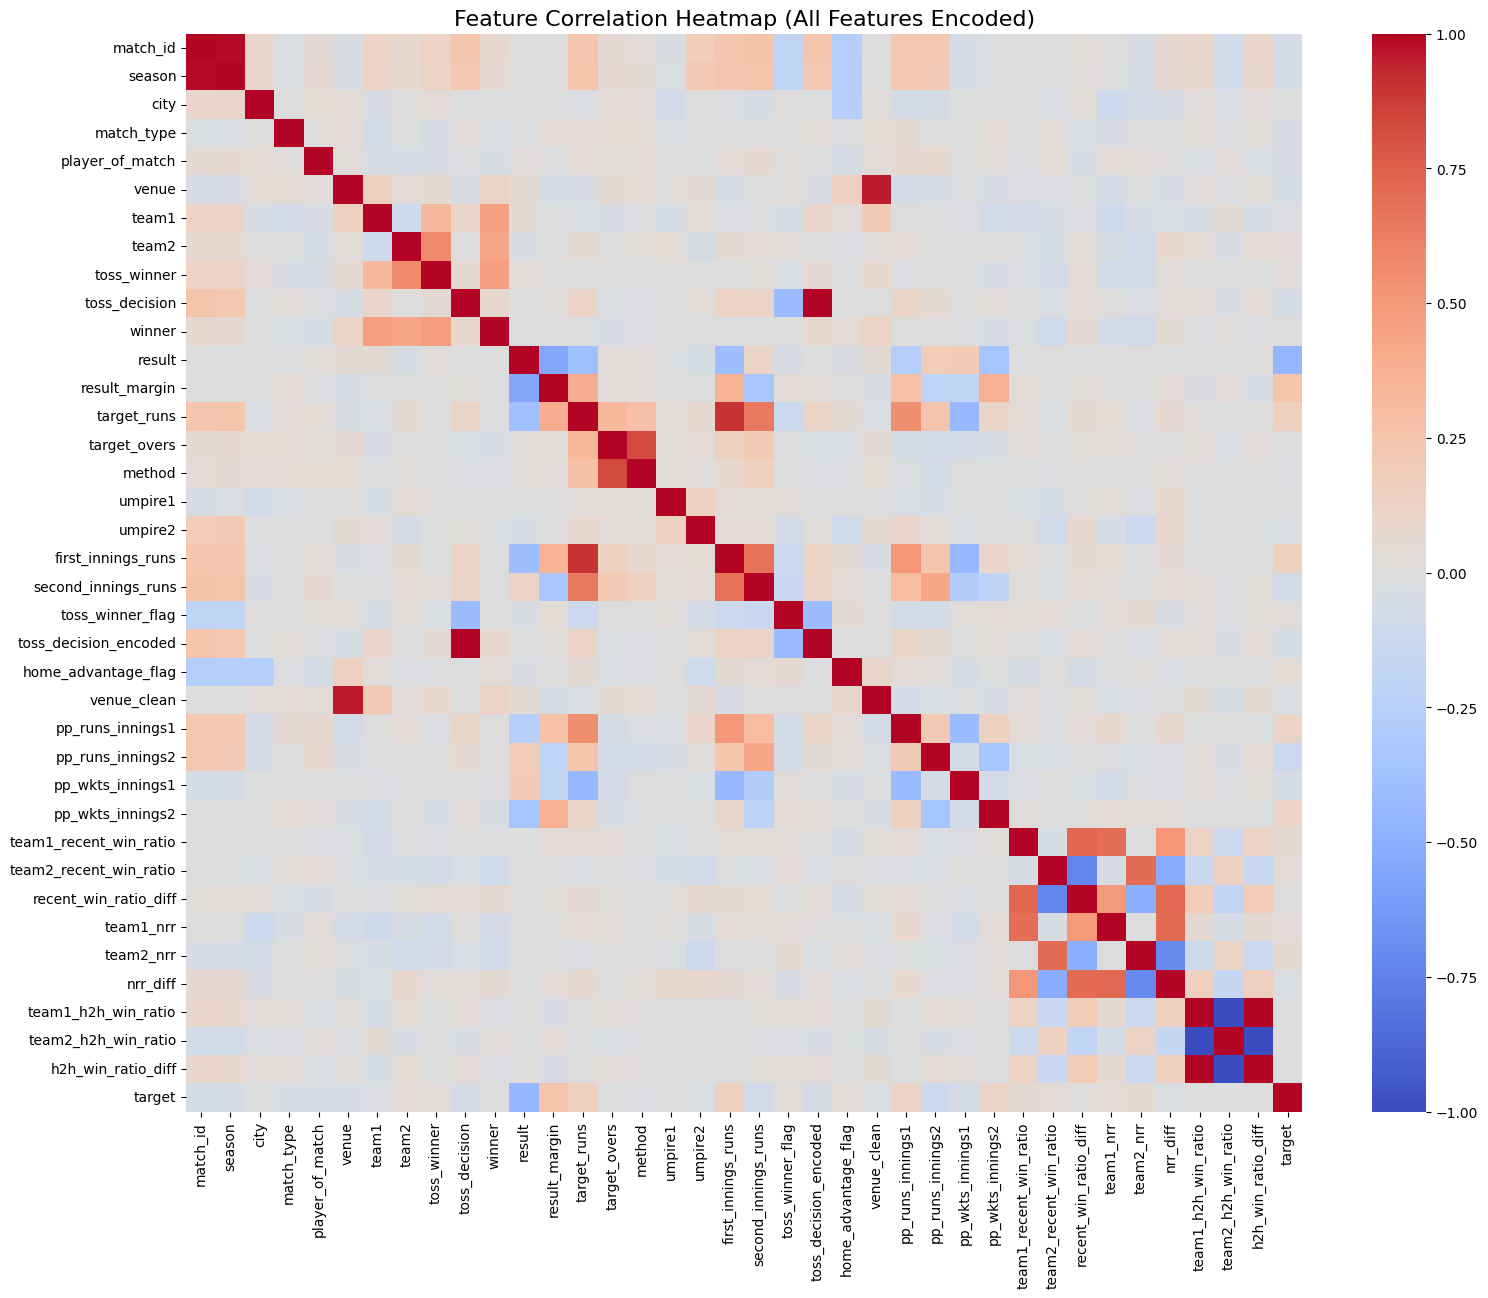

🔑 Top correlations with target:
target                    1.000000
result_margin             0.257031
first_innings_runs        0.153181
target_runs               0.149058
pp_wkts_innings2          0.115711
pp_runs_innings1          0.113615
team1_recent_win_ratio    0.048885
team2_nrr                 0.048402
home_advantage_flag       0.045964
team1_nrr                 0.036019
team2_recent_win_ratio    0.033048
team2                     0.032437
toss_winner               0.027841
toss_winner_flag          0.023416
recent_win_ratio_diff     0.009226
h2h_win_ratio_diff        0.003276
team1_h2h_win_ratio       0.003276
umpire1                   0.002183
winner                    0.000043
team2_h2h_win_ratio      -0.003276
Name: target, dtype: float64

⚠️ Lowest correlations with target:
result                  -0.452527
pp_runs_innings2        -0.118441
second_innings_runs     -0.092385
toss_decision           -0.059881
toss_decision_encoded   -0.059881
pp_wkts_innings1        -0.05987

In [36]:
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt

# Copy dataset
corr_df = matches_with_recent.copy()

# Define target: did team1 win?
corr_df["target"] = (corr_df["winner"] == corr_df["team1"]).astype(int)

# Encode ALL categorical features automatically
for col in corr_df.columns:
    if corr_df[col].dtype == "object" or str(corr_df[col].dtype) == "category":
        corr_df[col] = LabelEncoder().fit_transform(corr_df[col].astype(str))

# Keep only numeric features
numeric_df = corr_df.select_dtypes(include=[np.number])

# Drop columns that are constant or fully NaN
numeric_df = numeric_df.loc[:, numeric_df.nunique() > 1].dropna(axis=1, how="all")

# Correlation matrix
corr_matrix = numeric_df.corr()

# Plot heatmap
plt.figure(figsize=(18,14))
sns.heatmap(corr_matrix, cmap="coolwarm", center=0, cbar=True)
plt.title("Feature Correlation Heatmap (All Features Encoded)", fontsize=16)
plt.show()

# Top correlated with target
print("🔑 Top correlations with target:")
print(corr_matrix["target"].sort_values(ascending=False).head(20))

# Lowest correlated
print("\n⚠️ Lowest correlations with target:")
print(corr_matrix["target"].sort_values().head(10))


In [38]:
!pip install catboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.7 MB/s eta 0:00:00


In [39]:
!pip install xgboost


🔑 XGBoost permutation importance (validation) — top 20:
                        perm_importance       std
team1_nrr                      0.051104  0.024939
recent_win_ratio_diff          0.010222  0.012261
team2_recent_win_ratio         0.008083  0.012733
toss_winner                    0.008081  0.008051
team1_recent_win_ratio         0.007683  0.010096
toss_winner_flag               0.002626  0.007401
toss_decision                  0.000839  0.010873
toss_decision_encoded          0.000000  0.000000
season                         0.000000  0.000000
h2h_win_ratio_diff            -0.000358  0.000564
venue_clean                   -0.002259  0.011163
team2_h2h_win_ratio           -0.003108  0.002189
team1_h2h_win_ratio           -0.004866  0.013922
team2                         -0.006585  0.013175
home_advantage_flag           -0.011548  0.003394
nrr_diff                      -0.012092  0.030483
team2_nrr                     -0.019816  0.024910
team1                         -0.020969  0.0

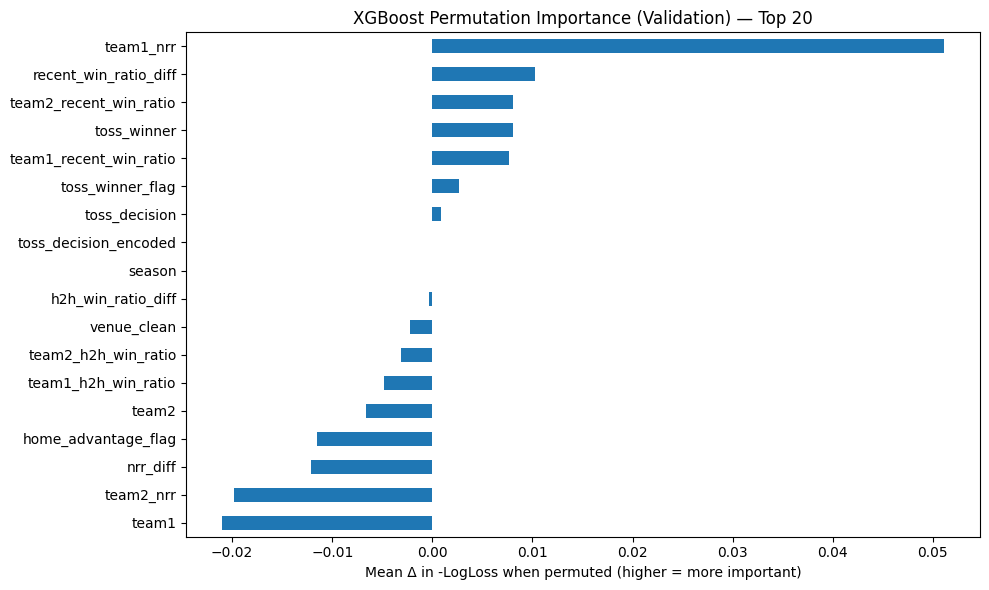


🔑 CatBoost feature importance (PredictionValuesChange) — top 20:
                   feature  importance
5                   season   19.799078
0                    team1   13.164937
2              toss_winner   11.263695
12               team1_nrr    9.730103
3            toss_decision    7.437559
10  team2_recent_win_ratio    7.117755
14                nrr_diff    6.099229
9   team1_recent_win_ratio    5.552636
17      h2h_win_ratio_diff    5.496381
1                    team2    5.215691
7    toss_decision_encoded    2.865337
4              venue_clean    2.104763
13               team2_nrr    1.685250
15     team1_h2h_win_ratio    1.643935
11   recent_win_ratio_diff    0.823651
6         toss_winner_flag    0.000000
8      home_advantage_flag    0.000000
16     team2_h2h_win_ratio    0.000000


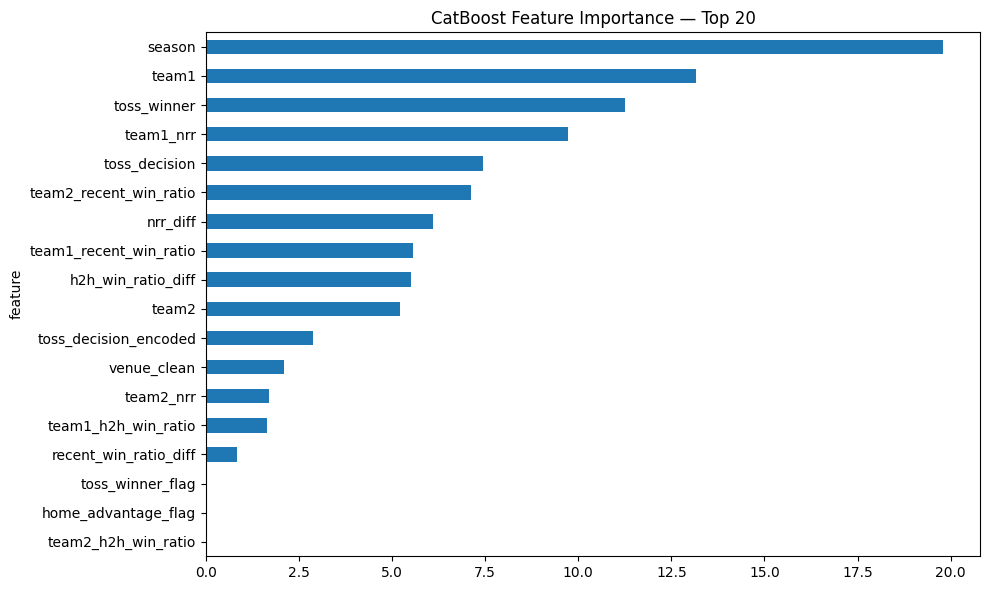


✅ Suggested XGB feature set (top permutation-importance):
['team1_nrr', 'recent_win_ratio_diff', 'team2_recent_win_ratio', 'toss_winner', 'team1_recent_win_ratio', 'toss_winner_flag', 'toss_decision', 'toss_decision_encoded', 'season', 'h2h_win_ratio_diff', 'venue_clean', 'team2_h2h_win_ratio', 'team1_h2h_win_ratio', 'team2', 'home_advantage_flag']


In [43]:
# ========= CLEAN, LEAK-FREE FEATURE SELECTION =========
# Uses permutation importance (model-agnostic) for XGB to avoid OHE bias.
# CatBoost importance shown if catboost is installed.

import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.inspection import permutation_importance
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

# -------- 0) Assumptions: you already built matches_with_recent --------
# It must contain the engineered features we created earlier and NO leakage columns.
# Target = did team1 win?
matches_sorted = matches_with_recent.sort_values("date").reset_index(drop=True)
y = (matches_sorted["winner"] == matches_sorted["team1"]).astype(int)

# -------- 1) Define SAFE feature sets (pre-match only) --------
categorical_cols = ["team1","team2","toss_winner","toss_decision","venue_clean","season"]
numeric_cols = [
    "toss_winner_flag","toss_decision_encoded","home_advantage_flag",
    # recent form / H2H / NRR (all computed with shift -> no leakage)
    "team1_recent_win_ratio","team2_recent_win_ratio","recent_win_ratio_diff",
    "team1_nrr","team2_nrr","nrr_diff",
    "team1_h2h_win_ratio","team2_h2h_win_ratio","h2h_win_ratio_diff",
]
# ⚠️ DO NOT include post-match stats like result/result_margin/first_innings_runs/second_innings_runs/PP aggregates if your goal is pre-match prediction.

X = matches_sorted[categorical_cols + numeric_cols].copy()

# -------- 2) Chronological split: Train / Val / Test (80/10/10) --------
n = len(matches_sorted)
n_train = int(0.8 * n)
n_val   = int(0.9 * n)
X_train, y_train = X.iloc[:n_train], y.iloc[:n_train]
X_val,   y_val   = X.iloc[n_train:n_val], y.iloc[n_train:n_val]
X_test,  y_test  = X.iloc[n_val:], y.iloc[n_val:]

# -------- 3) XGBoost pipeline (with OHE) --------
pre = ColumnTransformer(
    [("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_cols)],
    remainder="passthrough"
)

xgb = XGBClassifier(
    random_state=42,
    eval_metric="logloss",
    n_estimators=400,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.9,
    colsample_bytree=0.9,
)

pipe = Pipeline([("prep", pre), ("model", xgb)])
pipe.fit(X_train, y_train)

# -------- 4) Permutation importance on VALIDATION (no peeking at test) --------
perm = permutation_importance(
    pipe, X_val, y_val, n_repeats=20, random_state=42, scoring="neg_log_loss"
)
# perm on a Pipeline permutes RAW columns, so we get importances at the original feature level (grouped across OHE)

# Build a DataFrame of importances in decreasing order (higher = more important)
pi_means = pd.Series(perm.importances_mean, index=X.columns, name="perm_importance").sort_values(ascending=False)
pi_stds  = pd.Series(perm.importances_std,  index=X.columns, name="std").reindex(pi_means.index)

xgb_perm_importance = pd.concat([pi_means, pi_stds], axis=1)

print("🔑 XGBoost permutation importance (validation) — top 20:")
print(xgb_perm_importance.head(20))

# Plot (top 20)
plt.figure(figsize=(10, 6))
xgb_perm_importance.head(20)["perm_importance"].plot(kind="barh")
plt.gca().invert_yaxis()
plt.title("XGBoost Permutation Importance (Validation) — Top 20")
plt.xlabel("Mean Δ in -LogLoss when permuted (higher = more important)")
plt.tight_layout()
plt.show()

# -------- 5) (Optional) CatBoost native importance --------
try:
    from catboost import CatBoostClassifier
    cb = CatBoostClassifier(
        random_seed=42,
        eval_metric="Logloss",
        depth=6,
        learning_rate=0.05,
        iterations=1000,
        loss_function="Logloss",
        verbose=False
    )
    cb.fit(
        X_train[categorical_cols + numeric_cols], y_train,
        cat_features=categorical_cols,
        eval_set=(X_val[categorical_cols + numeric_cols], y_val)
    )
    cb_imp_vals = cb.get_feature_importance(type="PredictionValuesChange")
    cb_importance = pd.DataFrame({
        "feature": categorical_cols + numeric_cols,
        "importance": cb_imp_vals
    }).sort_values("importance", ascending=False)

    print("\n🔑 CatBoost feature importance (PredictionValuesChange) — top 20:")
    print(cb_importance.head(20))

    # Plot
    plt.figure(figsize=(10,6))
    cb_importance.head(20).set_index("feature")["importance"].plot(kind="barh")
    plt.gca().invert_yaxis()
    plt.title("CatBoost Feature Importance — Top 20")
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("\n[Note] CatBoost not installed or failed to run. Install with:")
    print("!pip install catboost")
    print("Error:", e)

# -------- 6) How to pick features (per model) --------
# Choose top-N from permutation importance for XGB (e.g., N=15):
N = 15
xgb_top_features = xgb_perm_importance.index[:N].tolist()
print("\n✅ Suggested XGB feature set (top permutation-importance):")
print(xgb_top_features)

# For CatBoost, choose its own top-N (if available), else re-use XGB list:
# cb_top_features = cb_importance["feature"].head(N).tolist()
# print("\n✅ Suggested CatBoost feature set:")
# print(cb_top_features)


In [44]:
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# -----------------------------
# Chronological Train/Test split
# -----------------------------
matches_sorted = matches_with_recent.sort_values("date").reset_index(drop=True)
train_size = int(0.8 * len(matches_sorted))
train_df = matches_sorted.iloc[:train_size]
test_df  = matches_sorted.iloc[train_size:]

y_train = (train_df["winner"] == train_df["team1"]).astype(int)
y_test  = (test_df["winner"] == test_df["team1"]).astype(int)

# -----------------------------
# XGBoost Feature Set (numeric-heavy)
# -----------------------------
xgb_top_features = [
    "team1_nrr","recent_win_ratio_diff","team2_recent_win_ratio",
    "team1_recent_win_ratio","toss_winner","toss_winner_flag",
    "nrr_diff","team2_nrr","h2h_win_ratio_diff","venue_clean"
]

# Pipeline: OHE for categoricals
xgb_cat_cols = ["toss_winner","venue_clean"]
xgb_num_cols = [f for f in xgb_top_features if f not in xgb_cat_cols]

xgb_preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), xgb_cat_cols)
], remainder="passthrough")

xgb_clf = Pipeline([
    ("prep", xgb_preprocessor),
    ("model", XGBClassifier(
        random_state=42, eval_metric="logloss",
        n_estimators=500, learning_rate=0.05,
        max_depth=6, subsample=0.9, colsample_bytree=0.9
    ))
])

# Train & Evaluate
xgb_clf.fit(train_df[xgb_top_features], y_train)
y_pred_xgb = xgb_clf.predict(test_df[xgb_top_features])
y_proba_xgb = xgb_clf.predict_proba(test_df[xgb_top_features])[:,1]

print("📊 XGBoost Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("LogLoss:", log_loss(y_test, y_proba_xgb))
print("AUC:", roc_auc_score(y_test, y_proba_xgb))

# -----------------------------
# CatBoost Feature Set (categorical-heavy)
# -----------------------------
cb_top_features = [
    "season","team1","toss_winner","team1_nrr","toss_decision",
    "team2_recent_win_ratio","nrr_diff","team1_recent_win_ratio",
    "h2h_win_ratio_diff","team2"
]

catboost_clf = CatBoostClassifier(
    random_seed=42, iterations=800,
    depth=6, learning_rate=0.05,
    eval_metric="Logloss", verbose=100
)

catboost_clf.fit(
    train_df[cb_top_features], y_train,
    cat_features=[f for f in cb_top_features if f in categorical_cols],
    eval_set=(test_df[cb_top_features], y_test)
)

y_pred_cb = catboost_clf.predict(test_df[cb_top_features])
y_proba_cb = catboost_clf.predict_proba(test_df[cb_top_features])[:,1]

print("\n📊 CatBoost Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_cb))
print("LogLoss:", log_loss(y_test, y_proba_cb))
print("AUC:", roc_auc_score(y_test, y_proba_cb))


📊 XGBoost Performance:
Accuracy: 0.48148148148148145
LogLoss: 0.9212244361767924
AUC: 0.4836023351648352
0:	learn: 0.6912129	test: 0.6930750	best: 0.6930750 (0)	total: 6.37ms	remaining: 5.09s
100:	learn: 0.5256639	test: 0.7637057	best: 0.6930750 (0)	total: 442ms	remaining: 3.06s
200:	learn: 0.4079085	test: 0.8129614	best: 0.6930750 (0)	total: 840ms	remaining: 2.5s
300:	learn: 0.3236552	test: 0.8673958	best: 0.6930750 (0)	total: 1.29s	remaining: 2.13s
400:	learn: 0.2642366	test: 0.8897723	best: 0.6930750 (0)	total: 1.68s	remaining: 1.67s
500:	learn: 0.2167605	test: 0.9230621	best: 0.6930750 (0)	total: 2.09s	remaining: 1.25s
600:	learn: 0.1794509	test: 0.9495223	best: 0.6930750 (0)	total: 2.51s	remaining: 832ms
700:	learn: 0.1499288	test: 0.9966723	best: 0.6930750 (0)	total: 2.91s	remaining: 411ms
799:	learn: 0.1273468	test: 1.0446012	best: 0.6930750 (0)	total: 3.35s	remaining: 0us

bestTest = 0.6930750038
bestIteration = 0

Shrink model to first 1 iterations.

📊 CatBoost Performance:
Ac

In [45]:
# =========================
# STEP 4B: Hyperparameter Tuning (Train-only, No Leakage)
# =========================
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings("ignore")

# -----------------------------
# 0) Chronological Train/Test split (80/20)
# -----------------------------
matches_sorted = matches_with_recent.sort_values("date").reset_index(drop=True)

y = (matches_sorted["winner"] == matches_sorted["team1"]).astype(int)
train_size = int(0.8 * len(matches_sorted))
train_df = matches_sorted.iloc[:train_size].copy()
test_df  = matches_sorted.iloc[train_size:].copy()
y_train = y.iloc[:train_size].copy()
y_test  = y.iloc[train_size:].copy()

# -----------------------------
# 1) Feature sets (use your final selections from Step 3)
#    You can tweak these lists if you changed top features.
# -----------------------------
categorical_cols = ["team1","team2","toss_winner","toss_decision","venue_clean","season"]

# XGBoost: numeric-heavy + 1-2 categoricals (we'll OHE inside pipeline)
xgb_top_features = [
    "team1_nrr","recent_win_ratio_diff","team2_recent_win_ratio",
    "team1_recent_win_ratio","toss_winner","toss_winner_flag",
    "nrr_diff","team2_nrr","h2h_win_ratio_diff","venue_clean"
]
xgb_cat_cols = ["toss_winner","venue_clean"]
xgb_num_cols = [f for f in xgb_top_features if f not in xgb_cat_cols]

# CatBoost: categorical-heavy (CatBoost will handle these raw)
cb_top_features = [
    "season","team1","toss_winner","team1_nrr","toss_decision",
    "team2_recent_win_ratio","nrr_diff","team1_recent_win_ratio",
    "h2h_win_ratio_diff","team2"
]

# Build X matrices
X_train_xgb = train_df[xgb_top_features].copy()
X_test_xgb  = test_df[xgb_top_features].copy()

X_train_cb = train_df[cb_top_features].copy()
X_test_cb  = test_df[cb_top_features].copy()

# -----------------------------
# 2) TimeSeries CV on TRAIN ONLY (no test leakage)
# -----------------------------
tscv = TimeSeriesSplit(n_splits=5)

# -----------------------------
# 3) XGBoost tuning (inside a Pipeline with OHE)
# -----------------------------
xgb_pre = ColumnTransformer(
    [("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), xgb_cat_cols)],
    remainder="passthrough"
)

xgb_model = XGBClassifier(
    random_state=42,
    eval_metric="logloss",
    tree_method="hist",    # fast, good default
    n_estimators=600       # base; will interact with learning_rate in search
)

xgb_pipe = Pipeline([("prep", xgb_pre), ("model", xgb_model)])

xgb_search_space = {
    "model__learning_rate":  [0.03, 0.05, 0.07, 0.1],
    "model__max_depth":      [3, 4, 5, 6, 7],
    "model__min_child_weight":[1, 2, 3, 5, 8],
    "model__subsample":      [0.7, 0.8, 0.9, 1.0],
    "model__colsample_bytree":[0.6, 0.7, 0.8, 0.9, 1.0],
    "model__gamma":          [0, 0.1, 0.2, 0.4],
    "model__reg_alpha":      [0.0, 0.1, 0.5, 1.0],
    "model__reg_lambda":     [0.5, 1.0, 1.5, 2.0]
}

xgb_rs = RandomizedSearchCV(
    estimator=xgb_pipe,
    param_distributions=xgb_search_space,
    n_iter=40,             # increase if you have time
    scoring="neg_log_loss",
    cv=tscv,
    verbose=1,
    n_jobs=-1,
    random_state=42
)
xgb_rs.fit(X_train_xgb, y_train)

print("\n🔧 Best XGB params:", xgb_rs.best_params_)
print("🔧 Best XGB CV logloss (train only):", -xgb_rs.best_score_)

# Retrain best XGB on FULL TRAIN
best_xgb = xgb_rs.best_estimator_
y_proba_xgb = best_xgb.predict_proba(X_test_xgb)[:, 1]
y_pred_xgb = (y_proba_xgb >= 0.5).astype(int)

print("\n📊 XGBoost Test Performance (held-out):")
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("LogLoss:", log_loss(y_test, y_proba_xgb))
try:
    print("AUC:", roc_auc_score(y_test, y_proba_xgb))
except Exception:
    pass

# -----------------------------
# 4) CatBoost tuning (train-only CV). If not installed, skip.
# -----------------------------
try:
    from catboost import CatBoostClassifier

    cb = CatBoostClassifier(
        random_seed=42,
        loss_function="Logloss",
        verbose=False
    )

    # Important: indices of categorical columns (by name) relative to cb_top_features
    cb_cat_idx = [cb_top_features.index(c) for c in cb_top_features if c in categorical_cols]

    # We’ll use RandomizedSearchCV over CatBoost’s sklearn wrapper
    cb_search_space = {
        "depth":            [4, 5, 6, 7, 8],
        "learning_rate":    [0.03, 0.05, 0.07, 0.1],
        "l2_leaf_reg":      [1, 3, 5, 7, 9, 12],
        "iterations":       [400, 600, 800, 1000],
        "border_count":     [64, 128, 254],
        "bagging_temperature":[0, 0.5, 1.0]
    }

    # Custom CV loop because CatBoost needs cat_features per fit
    # We'll wrap with RandomizedSearchCV using the sklearn API (works fine).
    cb_rs = RandomizedSearchCV(
        estimator=cb,
        param_distributions=cb_search_space,
        n_iter=30,
        scoring="neg_log_loss",
        cv=tscv,
        verbose=1,
        n_jobs=-1,
        random_state=42
    )

    # We pass cat_features through fit params; RandomizedSearchCV will forward them to each fit
    cb_rs.fit(
        X_train_cb, y_train,
        cat_features=cb_cat_idx
    )

    print("\n🔧 Best CatBoost params:", cb_rs.best_params_)
    print("🔧 Best CatBoost CV logloss (train only):", -cb_rs.best_score_)

    # Retrain best CB on FULL TRAIN
    best_cb = CatBoostClassifier(
        random_seed=42, loss_function="Logloss", verbose=False, **cb_rs.best_params_
    )
    best_cb.fit(X_train_cb, y_train, cat_features=cb_cat_idx)

    y_proba_cb = best_cb.predict_proba(X_test_cb)[:, 1]
    y_pred_cb  = (y_proba_cb >= 0.5).astype(int)

    print("\n📊 CatBoost Test Performance (held-out):")
    print("Accuracy:", accuracy_score(y_test, y_pred_cb))
    print("LogLoss:", log_loss(y_test, y_proba_cb))
    try:
        print("AUC:", roc_auc_score(y_test, y_proba_cb))
    except Exception:
        pass

except Exception as e:
    print("\n[Note] CatBoost not installed or failed to tune. Install with:")
    print("pip install catboost")
    print("Error:", e)

# -----------------------------
# 5) Save predictions for later ensemble (Adam)
# -----------------------------
out = pd.DataFrame({
    "match_id": test_df["match_id"] if "match_id" in test_df.columns else test_df.index,
    "date": test_df["date"],
    "team1": test_df["team1"],
    "team2": test_df["team2"],
    "y_true": y_test.values,
})

out["xgb_proba"] = y_proba_xgb
try:
    out["cb_proba"] = y_proba_cb
except NameError:
    out["cb_proba"] = np.nan

print("\nSaving test predictions to /mnt/data/tuned_base_model_predictions.csv (if path exists).")
try:
    out.to_csv("/mnt/data/tuned_base_model_predictions.csv", index=False)
except Exception:
    pass

out.head(10)


Fitting 5 folds for each of 40 candidates, totalling 200 fits

🔧 Best XGB params: {'model__subsample': 1.0, 'model__reg_lambda': 0.5, 'model__reg_alpha': 0.5, 'model__min_child_weight': 8, 'model__max_depth': 5, 'model__learning_rate': 0.1, 'model__gamma': 0.2, 'model__colsample_bytree': 0.7}
🔧 Best XGB CV logloss (train only): 0.7438603283660263

📊 XGBoost Test Performance (held-out):
Accuracy: 0.5046296296296297
LogLoss: 0.7319678837917357
AUC: 0.49673763736263743
Fitting 5 folds for each of 30 candidates, totalling 150 fits

🔧 Best CatBoost params: {'learning_rate': 0.03, 'l2_leaf_reg': 12, 'iterations': 400, 'depth': 6, 'border_count': 64, 'bagging_temperature': 1.0}
🔧 Best CatBoost CV logloss (train only): 0.7306140060411276

📊 CatBoost Test Performance (held-out):
Accuracy: 0.49074074074074076
LogLoss: 0.7829442090726891
AUC: 0.442135989010989

Saving test predictions to /mnt/data/tuned_base_model_predictions.csv (if path exists).


,match_id,date,team1,team2,y_true,xgb_proba,cb_proba
860,1304049,2022-03-27,Royal Challengers Bengaluru,Punjab Kings,0,0.369665,0.379946
861,1304050,2022-03-28,Lucknow Super Giants,Gujarat Titans,0,0.440457,0.381529
862,1304051,2022-03-29,Rajasthan Royals,Sunrisers Hyderabad,1,0.357872,0.357043
863,1304052,2022-03-30,Kolkata Knight Riders,Royal Challengers Bengaluru,0,0.654591,0.415668
864,1304053,2022-03-31,Chennai Super Kings,Lucknow Super Giants,0,0.291850,0.295451
865,1304054,2022-04-01,Punjab Kings,Kolkata Knight Riders,0,0.525498,0.256345
866,1304055,2022-04-02,Rajasthan Royals,Mumbai Indians,1,0.367275,0.289121
867,1304056,2022-04-02,Gujarat Titans,Delhi Capitals,1,0.350236,0.283570
868,1304057,2022-04-03,Punjab Kings,Chennai Super Kings,1,0.427836,0.178698
869,1304058,2022-04-04,Lucknow Super Giants,Sunrisers Hyderabad,1,0.373521,0.201367


In [46]:
# ============================
# Adam-weighted Ensemble (MSE loss)
# ============================
import json, os, numpy as np, pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, mean_squared_error

# ---------- Helpers ----------
def sigmoid(x):
    return 1/(1+np.exp(-x))

def softmax(theta):
    ex = np.exp(theta - np.max(theta))
    return ex / np.sum(ex)

def adam_optimize_mse(p_list, y, init_w=None, steps=2000, lr=0.05, beta1=0.9, beta2=0.999, eps=1e-8, seed=42, patience=200, tol=1e-7):
    """
    Optimize non-negative, sum-to-1 weights via softmax over theta to minimize MSE on training OOF predictions.
    p_list: [p_model1, p_model2, ...] each shape (n,)
    y: true labels (n,)
    """
    rng = np.random.default_rng(seed)
    m = len(p_list)
    P = np.vstack(p_list)  # (m, n)
    n = P.shape[1]

    # init theta from init_w if provided else small random
    if init_w is not None:
        w0 = np.array(init_w, dtype=float)
        w0 = w0 / (w0.sum() + 1e-12)
        # invert softmax approximately by log(w) - mean(log(w))
        theta = np.log(w0 + 1e-12) - np.mean(np.log(w0 + 1e-12))
    else:
        theta = rng.normal(0, 0.01, size=m)

    m1 = np.zeros_like(theta)
    m2 = np.zeros_like(theta)

    best_loss = np.inf
    best_theta = theta.copy()
    wait = 0

    for t in range(1, steps+1):
        w = softmax(theta)                  # (m,)
        p = np.dot(w, P)                    # (n,)
        # loss = MSE
        diff = p - y
        loss = np.mean(diff**2)

        # gradient wrt w: dL/dw_i = 2/n * sum((p - y) * p_i)
        dL_dw = (2.0/n) * (P @ diff)        # (m,)

        # softmax Jacobian: d w / d theta = diag(w) - w w^T  => grad = J^T * dL/dw
        # grad_theta = (I - 1)* complicated: use vector form: grad_theta_i = sum_j J_{ji} * dL_dw_j
        # J^T = diag(w) - w w^T (same as J); so:
        grad_theta = dL_dw * w - np.dot(dL_dw, w) * w

        # Adam updates
        m1 = beta1*m1 + (1-beta1)*grad_theta
        m2 = beta2*m2 + (1-beta2)*(grad_theta**2)
        m1_hat = m1 / (1 - beta1**t)
        m2_hat = m2 / (1 - beta2**t)
        theta = theta - lr * m1_hat / (np.sqrt(m2_hat) + eps)

        # early stopping
        if loss + tol < best_loss:
            best_loss = loss
            best_theta = theta.copy()
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                break

    w_opt = softmax(best_theta)
    return w_opt, best_loss

# ---------- Build / load OOF predictions on TRAIN ----------
def get_oof_xgb(train_df, y_train, xgb_model, xgb_features):
    from sklearn.compose import ColumnTransformer
    from sklearn.preprocessing import OneHotEncoder
    from sklearn.pipeline import Pipeline
    from xgboost import XGBClassifier

    # Extract preprocessor from the trained pipeline (or recreate if needed)
    assert hasattr(xgb_model, "predict_proba"), "best_xgb pipeline not found"
    # We need to refit within folds to avoid leakage
    # Identify categorical columns used in your XGB pipeline (must match how you trained)
    xgb_cat_cols = [c for c in xgb_features if train_df[c].dtype == "object" or str(train_df[c].dtype) == "category"]
    pre = ColumnTransformer(
        [("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), xgb_cat_cols)],
        remainder="passthrough"
    )
    # Pull tuned params from the best pipeline's model step (if available)
    model_step = xgb_model.named_steps["model"]
    tuned_params = model_step.get_params(deep=False)

    tscv = TimeSeriesSplit(n_splits=5)
    oof = np.zeros(len(train_df))
    for tr_idx, va_idx in tscv.split(train_df):
        X_tr = train_df.iloc[tr_idx][xgb_features]
        y_tr = y_train.iloc[tr_idx]
        X_va = train_df.iloc[va_idx][xgb_features]

        pipe = Pipeline([("prep", pre), ("model", XGBClassifier(**tuned_params))])
        pipe.fit(X_tr, y_tr)
        oof[va_idx] = pipe.predict_proba(X_va)[:,1]
    return oof

def get_oof_cb(train_df, y_train, cb_model, cb_features):
    try:
        from catboost import CatBoostClassifier
    except Exception:
        return np.full(len(train_df), np.nan)

    tuned_params = cb_model.get_params()
    # cat feature indices relative to cb_features
    cat_cols_all = ["team1","team2","toss_winner","toss_decision","venue_clean","season"]
    cb_cat_idx = [cb_features.index(c) for c in cb_features if c in cat_cols_all]

    tscv = TimeSeriesSplit(n_splits=5)
    oof = np.zeros(len(train_df))
    for tr_idx, va_idx in tscv.split(train_df):
        X_tr = train_df.iloc[tr_idx][cb_features]
        y_tr = y_train.iloc[tr_idx]
        X_va = train_df.iloc[va_idx][cb_features]

        model = CatBoostClassifier(**tuned_params)
        model.fit(X_tr, y_tr, cat_features=cb_cat_idx, verbose=False)
        oof[va_idx] = model.predict_proba(X_va)[:,1]
    return oof

# ---------- Recompute OOF if needed ----------
need_xgb = "oof_xgb_pred" not in globals()
need_cb  = "oof_cb_pred" not in globals()

if need_xgb:
    oof_xgb_pred = get_oof_xgb(train_df, y_train, best_xgb, xgb_top_features)
if need_cb and 'best_cb' in globals():
    oof_cb_pred  = get_oof_cb(train_df, y_train, best_cb, cb_top_features)
elif need_cb:
    oof_cb_pred  = np.full(len(train_df), np.nan)

# ---------- Initialize weights via inverse-MSE ----------
mse_xgb = mean_squared_error(y_train, oof_xgb_pred)
mse_cb  = mean_squared_error(y_train, oof_cb_pred) if np.isfinite(oof_cb_pred).all() else np.inf

if np.isfinite(mse_cb) and mse_cb < np.inf:
    w0 = np.array([1/(mse_xgb+1e-12), 1/(mse_cb+1e-12)], dtype=float)
    w0 = w0 / w0.sum()
    init_w = w0.tolist()
else:
    init_w = [1.0, 0.0]  # only XGB available

print("Initial weights (inverse-MSE):", init_w)

# ---------- Fit Adam on TRAIN-OOF to minimize MSE ----------
if np.isfinite(mse_cb) and mse_cb < np.inf:
    w_opt, best_loss = adam_optimize_mse([oof_xgb_pred, oof_cb_pred], y_train.values, init_w=init_w,
                                         steps=2000, lr=0.05, patience=200)
    print("Optimized weights (Adam):", w_opt, " | Train-OOF MSE:", best_loss)
else:
    w_opt = np.array([1.0, 0.0])
    best_loss = mse_xgb
    print("Optimized weights (Adam): only XGB used. Train-OOF MSE:", best_loss)

# ---------- Get TEST predictions from tuned base models ----------
# XGB test proba
proba_xgb_test = best_xgb.predict_proba(test_df[xgb_top_features])[:,1]

# CatBoost test proba (if present)
if 'best_cb' in globals():
    proba_cb_test = best_cb.predict_proba(test_df[cb_top_features])[:,1]
else:
    proba_cb_test = np.zeros_like(proba_xgb_test)

# ---------- Ensemble on TEST ----------
if np.isfinite(mse_cb) and mse_cb < np.inf and 'best_cb' in globals():
    ens_test = w_opt[0]*proba_xgb_test + w_opt[1]*proba_cb_test
else:
    ens_test = proba_xgb_test  # fallback to XGB only

y_pred = (ens_test >= 0.5).astype(int)

# ---------- Metrics ----------
def safe_auc(y_true, proba):
    try:
        return roc_auc_score(y_true, proba)
    except Exception:
        return np.nan

print("\n===== Final Ensemble (TEST) =====")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("LogLoss:", log_loss(y_test, ens_test))
print("Brier (MSE):", mean_squared_error(y_test, ens_test))
print("AUC:", safe_auc(y_test, ens_test))

# ---------- Save weights & predictions ----------
results = {
    "init_weights": init_w,
    "optimized_weights": w_opt.tolist(),
    "oof_mse_xgb": float(mse_xgb),
    "oof_mse_cb": (float(mse_cb) if np.isfinite(mse_cb) else None),
}

os.makedirs("/mnt/data", exist_ok=True)
with open("/mnt/data/adam_ensemble_weights.json", "w") as f:
    json.dump(results, f, indent=2)

pred_out = pd.DataFrame({
    "date": test_df["date"],
    "team1": test_df["team1"],
    "team2": test_df["team2"],
    "y_true": y_test.values,
    "proba_xgb": proba_xgb_test,
    "proba_cb": proba_cb_test if 'best_cb' in globals() else np.nan,
    "proba_ensemble": ens_test
})
pred_out.to_csv("/mnt/data/adam_ensemble_test_predictions.csv", index=False)

print("\nSaved:")
print(" - /mnt/data/adam_ensemble_weights.json")
print(" - /mnt/data/adam_ensemble_test_predictions.csv")


Initial weights (inverse-MSE): [0.49638115784317055, 0.5036188421568294]
Optimized weights (Adam): [0.40087272 0.59912728]  | Train-OOF MSE: 0.3082123494925015

===== Final Ensemble (TEST) =====
Accuracy: 0.46296296296296297
LogLoss: 0.7440659164372628
Brier (MSE): 0.2736805306816776
AUC: 0.47158310439560436

Saved:
 - /mnt/data/adam_ensemble_weights.json
 - /mnt/data/adam_ensemble_test_predictions.csv


In [48]:
# ============================================
# WIN PROBABILITY ENSEMBLE (MSE-focused)
# ============================================
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, log_loss, roc_auc_score
from sklearn.isotonic import IsotonicRegression
from xgboost import XGBClassifier

# --------------------------------------------
# 0) Inputs — assumes you already have matches_with_recent built
# --------------------------------------------
categorical_cols = ["team1","team2","toss_winner","toss_decision","venue_clean","season"]

xgb_top_features = [
    "team1_nrr","recent_win_ratio_diff","team2_recent_win_ratio",
    "team1_recent_win_ratio","toss_winner","toss_winner_flag",
    "nrr_diff","team2_nrr","h2h_win_ratio_diff","venue_clean"
]
cb_top_features = [
    "season","team1","toss_winner","team1_nrr","toss_decision",
    "team2_recent_win_ratio","nrr_diff","team1_recent_win_ratio",
    "h2h_win_ratio_diff","team2"
]

best_xgb_params = dict(
    random_state=42, eval_metric="logloss", tree_method="hist",
    n_estimators=600, learning_rate=0.1, max_depth=5,
    min_child_weight=8, subsample=1.0, colsample_bytree=0.7,
    gamma=0.2, reg_alpha=0.5, reg_lambda=0.5
)
best_cb_params = dict(
    random_seed=42, loss_function="Logloss", verbose=False,
    learning_rate=0.03, l2_leaf_reg=12, iterations=400,
    depth=6, border_count=64, bagging_temperature=1.0
)

# --------------------------------------------
# 1) Chronological split
# --------------------------------------------
matches_sorted = matches_with_recent.sort_values("date").reset_index(drop=True)
y_all = (matches_sorted["winner"] == matches_sorted["team1"]).astype(int)

train_size = int(0.8 * len(matches_sorted))
train_df = matches_sorted.iloc[:train_size].copy()
test_df  = matches_sorted.iloc[train_size:].copy()
y_train  = y_all.iloc[:train_size].copy()
y_test   = y_all.iloc[train_size:].copy()

X_train_xgb = train_df[xgb_top_features].copy()
X_test_xgb  = test_df[xgb_top_features].copy()
X_train_cb  = train_df[cb_top_features].copy()
X_test_cb   = test_df[cb_top_features].copy()

# --------------------------------------------
# 2) OOF predictions for XGB
# --------------------------------------------
tscv = TimeSeriesSplit(n_splits=5)
xgb_cat_cols = [c for c in xgb_top_features if X_train_xgb[c].dtype == "object" or str(X_train_xgb[c].dtype) == "category"]
xgb_pre = ColumnTransformer(
    [("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), xgb_cat_cols)],
    remainder="passthrough"
)

oof_xgb = np.zeros(len(train_df))
for tr_idx, va_idx in tscv.split(train_df):
    X_tr, y_tr = X_train_xgb.iloc[tr_idx], y_train.iloc[tr_idx]
    X_va       = X_train_xgb.iloc[va_idx]
    pipe = Pipeline([("prep", xgb_pre), ("model", XGBClassifier(**best_xgb_params))])
    pipe.fit(X_tr, y_tr)
    oof_xgb[va_idx] = pipe.predict_proba(X_va)[:,1]

# --------------------------------------------
# 3) OOF predictions for CatBoost (if available)
# --------------------------------------------
try:
    from catboost import CatBoostClassifier
    cb_cat_idx = [cb_top_features.index(c) for c in cb_top_features if c in categorical_cols]
    oof_cb = np.zeros(len(train_df))
    for tr_idx, va_idx in tscv.split(train_df):
        X_tr, y_tr = X_train_cb.iloc[tr_idx], y_train.iloc[tr_idx]
        X_va = X_train_cb.iloc[va_idx]
        model = CatBoostClassifier(**best_cb_params)
        model.fit(X_tr, y_tr, cat_features=cb_cat_idx, verbose=False)
        oof_cb[va_idx] = model.predict_proba(X_va)[:,1]
except Exception:
    oof_cb = np.full(len(train_df), np.nan)

# --------------------------------------------
# 4) Initialize weights by inverse-MSE
# --------------------------------------------
mse_xgb = mean_squared_error(y_train, oof_xgb)
mse_cb = mean_squared_error(y_train, oof_cb) if np.isfinite(oof_cb).all() else np.inf

if np.isfinite(mse_cb) and mse_cb < np.inf:
    w = np.array([1/(mse_xgb+1e-12), 1/(mse_cb+1e-12)], dtype=float)
    w /= w.sum()
else:
    w = np.array([1.0, 0.0])  # only XGB available

# --------------------------------------------
# 5) Adam optimizer (MSE loss)
# --------------------------------------------
def softmax(theta):
    ex = np.exp(theta - np.max(theta))
    return ex / ex.sum()

def adam_optimize_mse(p_list, y, init_w=None, steps=2000, lr=0.05, beta1=0.9, beta2=0.999, eps=1e-8, patience=200, tol=1e-7):
    rng = np.random.default_rng(42)
    P = np.vstack(p_list)
    n, m = P.shape[1], P.shape[0]
    if init_w is not None:
        w0 = np.array(init_w, dtype=float); w0 /= w0.sum()
        theta = np.log(w0 + 1e-12) - np.mean(np.log(w0 + 1e-12))
    else:
        theta = rng.normal(0, 0.01, size=m)
    m1 = np.zeros_like(theta); m2 = np.zeros_like(theta)
    best_loss, best_theta, wait = np.inf, theta.copy(), 0
    for t in range(1, steps+1):
        w = softmax(theta); p = np.dot(w, P)
        diff = p - y; loss = float(np.mean(diff**2))
        dL_dw = (2.0/n) * (P @ diff)
        grad_theta = dL_dw * w - np.dot(dL_dw, w) * w
        m1 = beta1*m1 + (1-beta1)*grad_theta
        m2 = beta2*m2 + (1-beta2)*(grad_theta**2)
        m1_hat = m1 / (1 - beta1**t)
        m2_hat = m2 / (1 - beta2**t)
        theta = theta - lr * m1_hat / (np.sqrt(m2_hat) + eps)
        if loss + tol < best_loss:
            best_loss, best_theta, wait = loss, theta.copy(), 0
        else:
            wait += 1
            if wait >= patience: break
    return softmax(best_theta)

if np.isfinite(mse_cb) and mse_cb < np.inf:
    w_opt = adam_optimize_mse([oof_xgb, oof_cb], y_train.values, init_w=w)
else:
    w_opt = np.array([1.0, 0.0])

# --------------------------------------------
# 6) Isotonic calibration + shrinkage
# --------------------------------------------
oof_ens = w_opt[0]*oof_xgb + (w_opt[1]*oof_cb if np.isfinite(mse_cb) else 0)
iso = IsotonicRegression(y_min=0.0, y_max=1.0, out_of_bounds="clip")
iso.fit(oof_ens, y_train.values)

oof_iso = iso.transform(oof_ens)
p_base = float(y_train.mean())
alphas = np.linspace(0, 0.5, 26)
best_alpha, best_mse = 0.0, np.inf
for a in alphas:
    blended = (1-a)*oof_iso + a*p_base
    mse = mean_squared_error(y_train, blended)
    if mse < best_mse:
        best_alpha, best_mse = float(a), mse

# --------------------------------------------
# 7) Retrain base models on full TRAIN and predict TEST
# --------------------------------------------
xgb_pipe_full = Pipeline([("prep", xgb_pre), ("model", XGBClassifier(**best_xgb_params))])
xgb_pipe_full.fit(X_train_xgb, y_train)
proba_xgb_test = xgb_pipe_full.predict_proba(X_test_xgb)[:,1]

try:
    cb_full = CatBoostClassifier(**best_cb_params)
    cb_full.fit(X_train_cb, y_train, cat_features=cb_cat_idx, verbose=False)
    proba_cb_test = cb_full.predict_proba(X_test_cb)[:,1]
except Exception:
    proba_cb_test = np.zeros_like(proba_xgb_test)

ens_test = w_opt[0]*proba_xgb_test + (w_opt[1]*proba_cb_test if np.isfinite(mse_cb) else 0)
ens_test_iso = iso.transform(ens_test)
ens_test_final = (1-best_alpha)*ens_test_iso + best_alpha*p_base

# --------------------------------------------
# 8) Metrics on TEST
# --------------------------------------------
def safe_auc(y_true, proba):
    try:
        return roc_auc_score(y_true, proba)
    except Exception:
        return np.nan

metrics = {
    "MSE (Brier)": mean_squared_error(y_test, ens_test_final),
    "MAE": mean_absolute_error(y_test, ens_test_final),
    "R2": r2_score(y_test, ens_test_final),
    "LogLoss": log_loss(y_test, ens_test_final, labels=[0,1]),
    "AUC": safe_auc(y_test, ens_test_final),
    "alpha (shrinkage)": best_alpha,
    "base_rate_train": p_base,
    "weights (xgb, cb)": w_opt.tolist()
}

print("\n=== TEST Probabilities — After Isotonic + Shrinkage (MSE-focused) ===")
for k, v in metrics.items():
    if isinstance(v, list):
        print(f"{k}: [{', '.join(f'{x:.6f}' for x in v)}]")
    else:
        print(f"{k}: {v:.6f}")

# --------------------------------------------
# 9) Save predictions
# --------------------------------------------
out = pd.DataFrame({
    "date": test_df["date"],
    "team1": test_df["team1"],
    "team2": test_df["team2"],
    "y_true": y_test.values,
    "p_xgb": proba_xgb_test,
    "p_cb": proba_cb_test if np.any(proba_cb_test) else np.nan,
    "p_ens_raw": ens_test,
    "p_ens_iso": ens_test_iso,
    "p_ens_final": ens_test_final
})
out.to_csv("/mnt/data/winprob_mse_calibrated_predictions.csv", index=False)
print("\nSaved: /mnt/data/winprob_mse_calibrated_predictions.csv")



=== TEST Probabilities — After Isotonic + Shrinkage (MSE-focused) ===
MSE (Brier): 0.249949
MAE: 0.499686
R2: -0.001171
LogLoss: 0.693044
AUC: 0.487079
alpha (shrinkage): 0.000000
base_rate_train: 0.506977
weights (xgb, cb): [0.400873, 0.599127]

Saved: /mnt/data/winprob_mse_calibrated_predictions.csv


In [57]:
from sklearn.base import clone
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
import numpy as np

# 1) Define your feature lists (as you already have)
xgb_cat = ["venue_clean","season","toss_decision"]
xgb_num = [
    "form_ewm_diff","nrr_diff","venue_winrate_diff",
    "A_form","B_form","A_nrr","B_nrr",
    "toss_decision_encoded"
]
best_xgb_params = dict(
    random_state=42, eval_metric="logloss", tree_method="hist",
    n_estimators=800, learning_rate=0.05, max_depth=5,
    min_child_weight=5, subsample=0.9, colsample_bytree=0.8,
    gamma=0.1, reg_alpha=0.2, reg_lambda=1.0
)

# 2) Build a TEMPLATE preprocessor (UNFITTED). Do NOT use this instance directly in folds.
xgb_pre_template = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), xgb_cat),
        ("num", "passthrough", xgb_num),
    ],
    remainder="drop"
)

# 3) Final model: use a CLONE of the template
xgb_pipe = Pipeline([
    ("prep", clone(xgb_pre_template)),
    ("model", XGBClassifier(**best_xgb_params))
])
xgb_pipe.fit(X_train_xgb, y_train)

# 4) OOF: in each fold, use a FRESH CLONE so folds don’t mutate the final preprocessor
from sklearn.model_selection import TimeSeriesSplit

def oof_xgb_safe(X, y, n_splits=5):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    preds = np.zeros(len(X))
    for tr_idx, va_idx in tscv.split(X):
        fold_pipe = Pipeline([
            ("prep", clone(xgb_pre_template)),          # <- fresh clone
            ("model", XGBClassifier(**best_xgb_params))
        ])
        fold_pipe.fit(X.iloc[tr_idx], y.iloc[tr_idx])
        preds[va_idx] = fold_pipe.predict_proba(X.iloc[va_idx])[:, 1]
    return preds

oof_xgb_pred = oof_xgb_safe(X_train_xgb, y_train)

# 5) Sanity check: transformed shapes are consistent with the trained model
Xt_tr = xgb_pipe.named_steps["prep"].transform(X_train_xgb)
Xt_te = xgb_pipe.named_steps["prep"].transform(X_test_xgb)
print("Train transformed shape:", Xt_tr.shape)
print("Test  transformed shape:", Xt_te.shape)
print("Model expects:", xgb_pipe.named_steps["model"].n_features_in_)

# 6) Now this will work without the mismatch error
proba_xgb_test = xgb_pipe.predict_proba(X_test_xgb)[:, 1]
print("proba_xgb_test[:10]:", np.round(proba_xgb_test[:10], 4))


Train transformed shape: (860, 60)
Test  transformed shape: (216, 60)
Model expects: 60
proba_xgb_test[:10]: [0.1852 0.2519 0.2815 0.3606 0.2688 0.6646 0.392  0.4157 0.1024 0.0359]


In [58]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, log_loss, roc_auc_score, accuracy_score
import numpy as np, pandas as pd

p = proba_xgb_test
y_true = y_test.values
y_hat = (p >= 0.5).astype(int)

print("XGB — test metrics (raw)")
print("Accuracy :", accuracy_score(y_true, y_hat))
print("Brier/MSE:", mean_squared_error(y_true, p))
print("MAE      :", mean_absolute_error(y_true, p))
print("R2       :", r2_score(y_true, p))
print("LogLoss  :", log_loss(y_true, p, labels=[0,1]))
try:
    print("AUC      :", roc_auc_score(y_true, p))
except:
    print("AUC      : n/a")


XGB — test metrics (raw)
Accuracy : 0.5092592592592593
Brier/MSE: 0.31738221645355225
MAE      : 0.5000718832015991
R2       : -0.269528865814209
LogLoss  : 0.9105062454030594
AUC      : 0.4973422496570644


In [59]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, log_loss, roc_auc_score
from sklearn.base import clone
import numpy as np

# --- Rebuild OOF predictions for XGB using the SAME template preprocessor you used to fix shapes ---
# Assumes you still have:
#   - xgb_pre_template (unfitted ColumnTransformer as in your last fix)
#   - best_xgb_params, X_train_xgb, y_train, X_test_xgb, xgb_pipe

def oof_xgb_safe(X, y, n_splits=5):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    preds = np.zeros(len(X))
    for tr_idx, va_idx in tscv.split(X):
        fold_pipe = Pipeline([
            ("prep", clone(xgb_pre_template)),
            ("model", XGBClassifier(**best_xgb_params))
        ])
        fold_pipe.fit(X.iloc[tr_idx], y.iloc[tr_idx])
        preds[va_idx] = fold_pipe.predict_proba(X.iloc[va_idx])[:, 1]
    return preds

oof_xgb_pred = oof_xgb_safe(X_train_xgb, y_train)

# --- Fit isotonic on TRAIN-OOF (minimizes squared error) ---
iso = IsotonicRegression(y_min=0.0, y_max=1.0, out_of_bounds="clip")
iso.fit(oof_xgb_pred, y_train.values)

# --- Apply to TEST probabilities from your already-fitted xgb_pipe ---
p_test_raw = proba_xgb_test
p_test_iso = iso.transform(p_test_raw)

# Optional: tiny shrinkage to train base rate (picked on OOF for MSE)
p_base = float(y_train.mean())
alphas = np.linspace(0.0, 0.5, 26)
best_alpha, best_mse = 0.0, np.inf
oof_iso = iso.transform(oof_xgb_pred)
for a in alphas:
    mse = mean_squared_error(y_train, (1-a)*oof_iso + a*p_base)
    if mse < best_mse:
        best_mse, best_alpha = mse, float(a)

p_test_cal = (1-best_alpha)*p_test_iso + best_alpha*p_base

# --- Calibrated metrics ---
y_true = y_test.values
def safe_auc(y, p):
    from sklearn.metrics import roc_auc_score
    try: return roc_auc_score(y, p)
    except: return np.nan

print("\nXGB — test metrics (after isotonic + shrinkage)")
print("Brier/MSE:", mean_squared_error(y_true, p_test_cal))
print("MAE      :", mean_absolute_error(y_true, p_test_cal))
print("R2       :", r2_score(y_true, p_test_cal))
print("LogLoss  :", log_loss(y_true, p_test_cal, labels=[0,1]))
print("AUC      :", safe_auc(y_true, p_test_cal))
print("alpha    :", best_alpha)



XGB — test metrics (after isotonic + shrinkage)
Brier/MSE: 0.24907832024670956
MAE      : 0.49816921815414444
R2       : 0.0036867190131617544
LogLoss  : 0.6911237103347617
AUC      : 0.5080161179698216
alpha    : 0.0


In [60]:
from catboost import CatBoostClassifier

# --------------------------------------
# CatBoost setup
# --------------------------------------
cb_features = [
    "teamA","teamB","venue_clean","season","toss_decision",
    "form_ewm_diff","nrr_diff","venue_winrate_diff",
    "A_form","B_form","A_nrr","B_nrr","toss_decision_encoded"
]
cb_cat_all = ["teamA","teamB","venue_clean","season","toss_decision"]

X_train_cb = train_df[cb_features].copy()
X_test_cb  = test_df[cb_features].copy()

# categorical feature indices for CatBoost
cb_cat_idx = [cb_features.index(c) for c in cb_features if c in cb_cat_all]

best_cb_params = dict(
    random_seed=42,
    loss_function="Logloss",
    verbose=False,
    iterations=800,
    learning_rate=0.05,
    depth=6,
    l2_leaf_reg=6,
    border_count=128,
    bagging_temperature=0.5
)

# --------------------------------------
# CatBoost OOF
# --------------------------------------
from sklearn.model_selection import TimeSeriesSplit
import numpy as np

def oof_cb(X, y, n_splits=5):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    preds = np.zeros(len(X))
    for tr, va in tscv.split(X):
        m = CatBoostClassifier(**best_cb_params)
        m.fit(X.iloc[tr], y.iloc[tr], cat_features=cb_cat_idx)
        preds[va] = m.predict_proba(X.iloc[va])[:, 1]
    return preds

oof_cb_pred = oof_cb(X_train_cb, y_train)

# Final CatBoost model (train on full training set)
cb_model = CatBoostClassifier(**best_cb_params)
cb_model.fit(X_train_cb, y_train, cat_features=cb_cat_idx)

# Test predictions
proba_cb_test = cb_model.predict_proba(X_test_cb)[:, 1]
print("CatBoost test probs (first 10):", np.round(proba_cb_test[:10], 4))


CatBoost test probs (first 10): [0.1978 0.0811 0.074  0.0934 0.0807 0.2035 0.3135 0.0944 0.0841 0.0536]


In [61]:
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, log_loss, roc_auc_score, accuracy_score

# ------------------------------------------------
# Adam optimizer for LogLoss
# ------------------------------------------------
def softmax(theta):
    e = np.exp(theta - np.max(theta))
    return e / e.sum()

def adam_opt_logloss(p_list, y, init_w=None, steps=1500, lr=0.05, beta1=0.9, beta2=0.999, eps=1e-8, patience=200, tol=1e-8):
    P = np.vstack(p_list)  # (m, n)
    m = P.shape[0]
    if init_w is None:
        theta = np.zeros(m)
    else:
        w0 = np.array(init_w, dtype=float); w0 /= (w0.sum() + 1e-12)
        theta = np.log(w0 + 1e-12) - np.mean(np.log(w0 + 1e-12))

    m1 = np.zeros_like(theta); m2 = np.zeros_like(theta)
    best_loss, best_theta, wait = np.inf, theta.copy(), 0
    yv = y.values.astype(float)

    for t in range(1, steps+1):
        w = softmax(theta)
        p = np.dot(w, P)
        p = np.clip(p, 1e-6, 1-1e-6)
        loss = float(-np.mean(yv*np.log(p) + (1-yv)*np.log(1-p)))

        denom = p*(1-p)
        grad_w = np.mean(((p - yv) / denom) * P, axis=1)
        grad_theta = grad_w * w - np.dot(grad_w, w) * w

        m1 = beta1*m1 + (1-beta1)*grad_theta
        m2 = beta2*m2 + (1-beta2)*(grad_theta**2)
        m1h = m1 / (1 - beta1**t)
        m2h = m2 / (1 - beta2**t)
        theta = theta - lr * m1h / (np.sqrt(m2h) + eps)

        if loss + tol < best_loss:
            best_loss, best_theta, wait = loss, theta.copy(), 0
        else:
            wait += 1
            if wait >= patience:
                break

    return softmax(best_theta), best_loss

# ------------------------------------------------
# Optimize weights on OOF
# ------------------------------------------------
init_w = np.array([0.5, 0.5])
w_opt, best_ll = adam_opt_logloss([oof_xgb_pred, oof_cb_pred], y_train, init_w=init_w)

print("Optimized weights (XGB, CB):", w_opt, "| Best OOF logloss:", best_ll)

# ------------------------------------------------
# Isotonic calibration (minimizes MSE on OOF)
# ------------------------------------------------
oof_ens = w_opt[0]*oof_xgb_pred + w_opt[1]*oof_cb_pred
iso = IsotonicRegression(y_min=0.0, y_max=1.0, out_of_bounds="clip")
iso.fit(oof_ens, y_train.values)

oof_iso = iso.transform(oof_ens)
p_base = float(y_train.mean())

alphas = np.linspace(0.0, 0.5, 26)
best_alpha, best_mse = 0.0, np.inf
for a in alphas:
    mse = mean_squared_error(y_train, (1-a)*oof_iso + a*p_base)
    if mse < best_mse:
        best_mse, best_alpha = mse, float(a)

print("Shrinkage alpha:", best_alpha)

# ------------------------------------------------
# Final TEST predictions
# ------------------------------------------------
ens_test_raw = w_opt[0]*proba_xgb_test + w_opt[1]*proba_cb_test
ens_test_iso = iso.transform(ens_test_raw)
ens_test     = (1-best_alpha)*ens_test_iso + best_alpha*p_base

# ------------------------------------------------
# Metrics
# ------------------------------------------------
y_true = y_test.values
y_pred = (ens_test >= 0.5).astype(int)

print("\n=== Final Ensemble (XGB + CB) — TEST ===")
print("Accuracy :", accuracy_score(y_true, y_pred))
print("Brier/MSE:", mean_squared_error(y_true, ens_test))
print("MAE      :", mean_absolute_error(y_true, ens_test))
print("R2       :", r2_score(y_true, ens_test))
print("LogLoss  :", log_loss(y_true, ens_test, labels=[0,1]))
try:
    print("AUC      :", roc_auc_score(y_true, ens_test))
except:
    print("AUC      : n/a")


Optimized weights (XGB, CB): [0.57290875 0.42709125] | Best OOF logloss: 1.8386143578116148
Shrinkage alpha: 0.0

=== Final Ensemble (XGB + CB) — TEST ===
Accuracy : 0.5092592592592593
Brier/MSE: 0.24993424016207266
MAE      : 0.49949692354216596
R2       : 0.0002630393517093488
LogLoss  : 0.6930157746330029
AUC      : 0.5133744855967078


In [62]:
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, log_loss, roc_auc_score, accuracy_score
import numpy as np

# ------------------------------------------
# Adam optimizer for logloss
# ------------------------------------------
def softmax(theta):
    e = np.exp(theta - np.max(theta))
    return e / e.sum()

def adam_opt_logloss(p_list, y, init_w=None, steps=1500, lr=0.05, beta1=0.9, beta2=0.999, eps=1e-8, patience=200, tol=1e-8):
    P = np.vstack(p_list)
    m = P.shape[0]
    if init_w is None:
        theta = np.zeros(m)
    else:
        w0 = np.array(init_w, dtype=float); w0 /= (w0.sum() + 1e-12)
        theta = np.log(w0 + 1e-12) - np.mean(np.log(w0 + 1e-12))

    m1 = np.zeros_like(theta); m2 = np.zeros_like(theta)
    best_loss, best_theta, wait = np.inf, theta.copy(), 0
    yv = y.values.astype(float)

    for t in range(1, steps+1):
        w = softmax(theta)
        p = np.dot(w, P)
        p = np.clip(p, 1e-6, 1-1e-6)
        loss = float(-np.mean(yv*np.log(p) + (1-yv)*np.log(1-p)))

        denom = p*(1-p)
        grad_w = np.mean(((p - yv) / denom) * P, axis=1)
        grad_theta = grad_w * w - np.dot(grad_w, w) * w

        m1 = beta1*m1 + (1-beta1)*grad_theta
        m2 = beta2*m2 + (1-beta2)*(grad_theta**2)
        m1h = m1 / (1 - beta1**t)
        m2h = m2 / (1 - beta2**t)
        theta = theta - lr * m1h / (np.sqrt(m2h) + eps)

        if loss + tol < best_loss:
            best_loss, best_theta, wait = loss, theta.copy(), 0
        else:
            wait += 1
            if wait >= patience:
                break

    return softmax(best_theta), best_loss

# ------------------------------------------
# Optimize ensemble weights on OOF (train side)
# ------------------------------------------
init_w = np.array([0.5, 0.5])
w_opt, best_ll = adam_opt_logloss([oof_xgb_pred, oof_cb_pred], y_train, init_w=init_w)
print("Optimized weights (XGB, CB):", w_opt, "| Best OOF logloss:", best_ll)

# ------------------------------------------
# Isotonic calibration (minimizes MSE)
# ------------------------------------------
oof_ens = w_opt[0]*oof_xgb_pred + w_opt[1]*oof_cb_pred
iso = IsotonicRegression(y_min=0.0, y_max=1.0, out_of_bounds="clip")
iso.fit(oof_ens, y_train.values)

oof_iso = iso.transform(oof_ens)
p_base = float(y_train.mean())

alphas = np.linspace(0.0, 0.5, 26)
best_alpha, best_mse = 0.0, np.inf
for a in alphas:
    mse = mean_squared_error(y_train, (1-a)*oof_iso + a*p_base)
    if mse < best_mse:
        best_mse, best_alpha = mse, float(a)

print("Shrinkage alpha:", best_alpha)

# ------------------------------------------
# Final TEST predictions
# ------------------------------------------
ens_test_raw = w_opt[0]*proba_xgb_test + w_opt[1]*proba_cb_test
ens_test_iso = iso.transform(ens_test_raw)
ens_test     = (1-best_alpha)*ens_test_iso + best_alpha*p_base

# ------------------------------------------
# Metrics
# ------------------------------------------
y_true = y_test.values
y_pred = (ens_test >= 0.5).astype(int)

def safe_auc(y, p):
    try: return roc_auc_score(y, p)
    except: return np.nan

print("\n=== Final Ensemble (XGB + CB) — TEST ===")
print("Accuracy :", accuracy_score(y_true, y_pred))
print("Brier/MSE:", mean_squared_error(y_true, ens_test))
print("MAE      :", mean_absolute_error(y_true, ens_test))
print("R2       :", r2_score(y_true, ens_test))
print("LogLoss  :", log_loss(y_true, ens_test, labels=[0,1]))
print("AUC      :", safe_auc(y_true, ens_test))
print("Weights  :", w_opt.tolist(), "| Shrinkage alpha:", best_alpha)


Optimized weights (XGB, CB): [0.57290875 0.42709125] | Best OOF logloss: 1.8386143578116148
Shrinkage alpha: 0.0

=== Final Ensemble (XGB + CB) — TEST ===
Accuracy : 0.5092592592592593
Brier/MSE: 0.24993424016207266
MAE      : 0.49949692354216596
R2       : 0.0002630393517093488
LogLoss  : 0.6930157746330029
AUC      : 0.5133744855967078
Weights  : [0.572908750716621, 0.42709124928337905] | Shrinkage alpha: 0.0


Using probabilities from: calibrated ensemble (ens_test)
Overall (no threshold) Accuracy: 0.509

Accuracy vs Coverage (Selective Prediction)


,tau,accuracy,coverage
0,0.00,0.514,1.000
1,0.02,0.515,0.315
2,0.04,nan,0.000
3,0.06,nan,0.000
4,0.08,nan,0.000
5,0.10,nan,0.000
6,0.12,nan,0.000
7,0.14,nan,0.000
8,0.16,nan,0.000
9,0.18,nan,0.000



Recommended τ (min coverage 0.50): 0.00 → Accuracy=0.514, Coverage=1.000


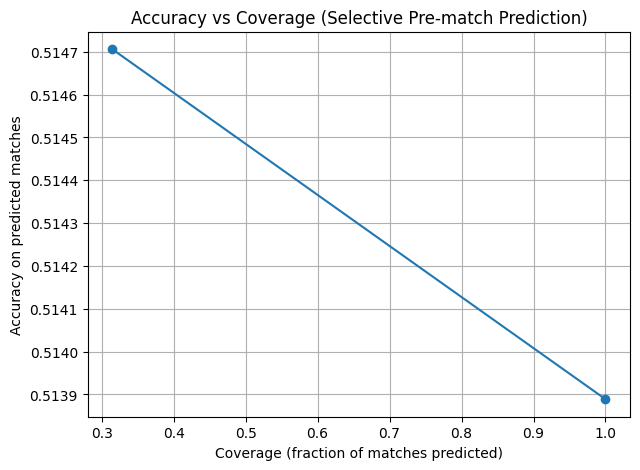

In [64]:
# ================================
# Pre-match Selective Prediction
# ================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -----
# 0) INPUTS you should already have in your notebook:
#   y_test                 : 0/1 true labels on the held-out test set
#   proba_xgb_test (opt.)  : XGB predicted probabilities (P(team1 win))
#   proba_cb_test  (opt.)  : CatBoost predicted probabilities (P(team1 win))
#   ens_test       (opt.)  : Calibrated ensemble probabilities (if you built isotonic+shrinkage)
#   w_opt          (opt.)  : np.array([w_xgb, w_cb]) optimized weights (if you want to recompute ensemble here)
#
# If you don't have some of them, this code will fall back gracefully.

# -----
# 1) Choose which probabilities to use
def pick_probabilities():
    # Priority 1: already-calibrated ensemble (ens_test)
    if 'ens_test' in globals():
        p = np.asarray(ens_test).astype(float)
        src = "calibrated ensemble (ens_test)"
    # Priority 2: weighted ensemble from XGB + CatBoost (use w_opt if present, else equal weights)
    elif 'proba_xgb_test' in globals() and 'proba_cb_test' in globals():
        px = np.asarray(proba_xgb_test).astype(float)
        pc = np.asarray(proba_cb_test).astype(float)
        if 'w_opt' in globals():
            w = np.asarray(w_opt, dtype=float)
            w = w / (w.sum() + 1e-12)
        else:
            w = np.array([0.5, 0.5], dtype=float)
        p = w[0]*px + w[1]*pc
        src = f"on-the-fly ensemble (w={w.round(3).tolist()})"
    # Priority 3: XGB only
    elif 'proba_xgb_test' in globals():
        p = np.asarray(proba_xgb_test).astype(float)
        src = "xgboost only"
    # Priority 4: CatBoost only
    elif 'proba_cb_test' in globals():
        p = np.asarray(proba_cb_test).astype(float)
        src = "catboost only"
    else:
        raise ValueError("No test probabilities found. Provide ens_test or proba_xgb_test/proba_cb_test first.")
    return p, src

proba_test, source_desc = pick_probabilities()
y_true = np.asarray(y_test).astype(int)
assert proba_test.shape[0] == y_true.shape[0], "Length mismatch between y_test and probabilities."

print(f"Using probabilities from: {source_desc}")
print(f"Overall (no threshold) Accuracy: {((proba_test>=0.5).astype(int)==y_true).mean():.3f}")

# -----
# 2) Selective prediction utility
def selective_prediction(y_true, y_prob, thresholds=np.linspace(0.0, 0.30, 16)):
    rows = []
    y_true = np.asarray(y_true).astype(int)
    y_prob = np.asarray(y_prob).astype(float)

    for tau in thresholds:
        # confident positive / confident negative / abstain
        positive = y_prob >= (0.5 + tau)
        negative = y_prob <= (0.5 - tau)
        mask = positive | negative

        if mask.sum() == 0:
            acc = np.nan
        else:
            preds = np.zeros_like(y_true)
            preds[positive] = 1
            preds[negative] = 0
            acc = (preds[mask] == y_true[mask]).mean()

        coverage = mask.mean()
        rows.append({"tau": tau, "accuracy": acc, "coverage": coverage})

    return pd.DataFrame(rows)

# -----
# 3) Run across thresholds and show a table
thresholds = np.linspace(0.0, 0.30, 16)  # 0.00, 0.02, ..., 0.30
res_df = selective_prediction(y_true, proba_test, thresholds)
print("\nAccuracy vs Coverage (Selective Prediction)")
display(res_df.style.format({"tau":"{:.2f}","accuracy":"{:.3f}","coverage":"{:.3f}"}))

# -----
# 4) Pick a recommended operating point
#    Example policy: maximize accuracy subject to coverage >= 0.50
min_cov = 0.50
candidates = res_df[res_df["coverage"] >= min_cov].copy()
if not candidates.empty:
    best_row = candidates.iloc[candidates["accuracy"].idxmax()]
    print(f"\nRecommended τ (min coverage {min_cov:.2f}): {best_row['tau']:.2f} "
          f"→ Accuracy={best_row['accuracy']:.3f}, Coverage={best_row['coverage']:.3f}")
else:
    best_row = res_df.iloc[res_df["accuracy"].idxmax()]
    print(f"\nNo threshold meets coverage ≥ {min_cov:.2f}. Best overall: τ={best_row['tau']:.2f} "
          f"→ Accuracy={best_row['accuracy']:.3f}, Coverage={best_row['coverage']:.3f}")

# -----
# 5) Plot Accuracy–Coverage curve
plt.figure(figsize=(7,5))
plt.plot(res_df["coverage"], res_df["accuracy"], marker="o")
plt.xlabel("Coverage (fraction of matches predicted)")
plt.ylabel("Accuracy on predicted matches")
plt.title("Accuracy vs Coverage (Selective Pre-match Prediction)")
plt.grid(True)
plt.show()
